In [1]:
import sys
!{sys.executable} -m pip install torch

     |████████████████████████████████| 881.9 MB 5.4 kB/s              


In [3]:
import torch
print(torch.__version__)
print(torch.version.cuda)

1.10.2+cu102
10.2


In [3]:
!{sys.executable} -m pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.2+cu102.html
!{sys.executable} -m pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.2+cu102.html
!{sys.executable} -m pip install torch-geometric
!{sys.executable} -m pip install ray
!{sys.executable} -m pip install "ray[tune]"
!{sys.executable} -m pip install -Uqq ipdb

Looking in links: https://data.pyg.org/whl/torch-1.10.2+cu102.html
     |████████████████████████████████| 8.0 MB 31.6 MB/s            
Looking in links: https://data.pyg.org/whl/torch-1.10.2+cu102.html
     |████████████████████████████████| 2.9 MB 49.6 MB/s            
     |████████████████████████████████| 370 kB 28.0 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 231 kB 113.6 MB/s            
     |████████████████████████████████| 41 kB 153 kB/s             
  Created wheel for torch-geometric: filename=torch_geometric-2.0.3-py3-none-any.whl size=581953 sha256=b8d72f6cecb6b4c6aecee3288eaabca1222d5d9daf12120f1c8cb57aea3b9c78
  Stored in directory: /home/ec2-user/.cache/pip/wheels/d2/48/63/193500a1360033fb617b90aede62d33ef14dc8e5f5c5f0972a
Successfully built torch-geometric
     |████████████████████████████████| 53.2 MB 4.3 kB/s             
     |████████████████████████████████| 4.1 MB 73.9 MB/s            
     |███████████████

     |████████████████████████████████| 461 kB 102.8 MB/s            
  Attempting uninstall: filelock
    Found existing installation: filelock 3.0.12
    Uninstalling filelock-3.0.12:
      Successfully uninstalled filelock-3.0.12
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.15.2
    Uninstalling protobuf-3.15.2:
      Successfully uninstalled protobuf-3.15.2
     |████████████████████████████████| 125 kB 28.3 MB/s            


In [4]:
#for hyper param optimization
import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial

# Import Python built-in libraries
import os
import copy
import pickle
import random
import time
import ipdb

import math

# Import pip libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm, trange

# Import torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch_geometric.utils import add_self_loops, degree

# Import PyG packages
import torch_geometric as pyg
import torch_geometric.data as pyg_data
import torch_geometric.utils
from torch_geometric.typing import Adj, OptTensor
import torch_sparse

In [5]:
class GraphDataset(pyg_data.InMemoryDataset):
    def __init__(self, root, file_name, transform=None, pre_transform=None):
        self.file_name = file_name
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [f'{self.file_name}.txt']

    @property
    def processed_file_names(self):
        return [f'{self.file_name}.pt']

    def download(self):
        pass

    def process(self):
        raw_data_file = f'{self.raw_dir}/{self.raw_file_names[0]}'
        with open(raw_data_file, 'rb') as f:
            sessions = pickle.load(f)
        data_list = []

        for session in range(len(sessions[0])):
            session, y = sessions[0][session], sessions[1][session]
            codes, uniques = pd.factorize(session)
            senders, receivers = codes[:-1], codes[1:]

            # Build Data instance
            edge_index = torch.tensor([senders, receivers], dtype=torch.long)
            x = torch.tensor(uniques, dtype=torch.long).unsqueeze(1)
            y = torch.tensor([y[0]], dtype=torch.long)
            data_list.append(pyg_data.Data(x=x, edge_index=edge_index, y=y))

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [6]:
class GatedSessionGraphConv(pyg.nn.conv.MessagePassing):
    def __init__(self, out_channels, model_type, K, aggr: str = 'add', add_self_loops=False, **kwargs):
        super().__init__(aggr=aggr, **kwargs)

        self.out_channels = out_channels
        self.model_type = model_type
        self.add_self_loops = add_self_loops
        self.K = K

        self.gru = torch.nn.GRUCell(out_channels, out_channels, bias=False)

    def forward(self, x, edge_index):
        #normalize directed graph A * D^-1
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-1.0)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row]

        embs = [x]
        emb_k = x

        # multi-scale diffusion
        for i in range(self.K):
            emb_k = self.propagate(edge_index, x=emb_k, norm=norm)
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1)  # E^K

        return emb_final


    def message(self, x_j, norm):
        return norm.view(-1,1) * x_j


    def message_and_aggregate(self, adj_t, x):
        return np.matmul(adj_t, x)


In [7]:
class SRGNN(nn.Module):
    def __init__(self, hidden_size, n_items, model_type, K, normalize):
        super(SRGNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_items = n_items
        self.model_type = model_type
        self.K = K
        self.normalize = normalize

        self.embedding = nn.Embedding(self.n_items, self.hidden_size)
        self.gated = GatedSessionGraphConv(self.hidden_size, self.model_type, self.K)

        self.q = nn.Linear(self.hidden_size, 1)
        self.W_1 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.W_2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.W_3 = nn.Linear(2 * self.hidden_size, self.hidden_size, bias=False)

        if self.normalize:
            nn.init.normal_(self.embedding.weight, std=0.1)

    def reset_parameters(self):
        pass  # There are no layer parameters to learn.

    def forward(self, data):
        x, edge_index, batch_map = data.x, data.edge_index, data.batch

        # (0)
        embedding = self.embedding(x).squeeze()

        # (1)-(5)
        # ipdb.set_trace()
        v_i = self.gated(embedding, edge_index)

        # Divide nodes by session
        sections = list(torch.bincount(batch_map).cpu())
        v_i_split = torch.split(v_i, sections)

        v_n, v_n_repeat = [], []
        for session in v_i_split:
            v_n.append(session[-1])
            v_n_repeat.append(
                session[-1].view(1, -1).repeat(session.shape[0], 1))
        v_n, v_n_repeat = torch.stack(v_n), torch.cat(v_n_repeat, dim=0)

        q1 = self.W_1(v_n_repeat)
        q2 = self.W_2(v_i)

        # (6)
        alpha = self.q(F.sigmoid(q1 + q2))
        s_g_split = torch.split(alpha * v_i, sections)

        s_g = []
        for session in s_g_split:
            s_g_session = torch.sum(session, dim=0)  # gevoelig voor aantal producten in je huidige sessie?
            s_g.append(s_g_session)
        s_g = torch.stack(s_g)

        # (7)
        s_l = v_n
        s_h = self.W_3(torch.cat([s_l, s_g], dim=-1))

        # (8)
        z = torch.mm(self.embedding.weight, s_h.T).T
        return z

In [8]:
def test(loader, test_model, is_validation=False, save_model_preds=False):
    test_model.eval()

    # Define K for Hit@K metrics.
    k = 20
    correct = 0
    top_k_correct = []
    top_k_mrr = []

    for _, data in enumerate(loader):
        data.to('cpu') #initial cuda
        with torch.no_grad():
            score = test_model(data)
            pred = score.max(dim=1)[1]
            label = data.y

        correct += pred.eq(label).sum().item()

        sub_scores = score.topk(20)[1]
        sub_scores = sub_scores.cpu().detach().numpy()
        # test to calculate MRR

        for ele in range(sub_scores.shape[0]):
            top_k_pred = sub_scores[ele]

            if label[ele].item() in top_k_pred:
                top_k_correct.append(1)
                position = np.where(top_k_pred == label[ele].item())[0][0] + 1
                top_k_mrr.append(1 / position)
            else:
                top_k_mrr.append(0)
                top_k_correct.append(0)

    mrr = np.mean(top_k_mrr)
    hit_rate = np.mean(top_k_correct)

    print(f'The MRR@20 : {mrr} HitRate@20 : {hit_rate}')

    if not is_validation:
        return correct / len(loader), hit_rate, mrr
    else:
        return correct / len(loader), hit_rate, mrr

In [9]:
def train_hyper(config, checkpoint_dir=None, data_dir=None):
    model = SRGNN(config["hidden_dim"], config["num_items"], config["model_type"], config["K"], config['normalize'])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=config["lr"],
                                 weight_decay=config["l2_penalty"])

    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=config["step"],
                                          gamma=config["weight_decay"])
    
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
        
    train_dataset = GraphDataset('/home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/data/yoochoose1_64', 'train_tr')

    train_loader = pyg_data.DataLoader(train_dataset,
                                       batch_size=config["batch_size"],
                                       shuffle=False,
                                       drop_last=False)
    
    val_dataset = GraphDataset('/home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/data/yoochoose1_64', 'train_valid')

    val_loader = pyg_data.DataLoader(val_dataset,
                                     batch_size=config["batch_size"],
                                     shuffle=False,
                                     drop_last=False)

    # Train
    losses = []
    test_accs = []
    test_mrr = []
    top_k_accs = []
    top_k_mrrs = []

    best_acc = 0
    best_model = None

    for epoch in range(config["epochs"]):
        total_loss = 0
        model.train()
        for _, batch in enumerate(train_loader):
            batch.to('cpu') #initial gpu
            optimizer.zero_grad()

            pred = model(batch)
            label = batch.y
            loss = criterion(pred, label)

            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs

        total_loss /= len(train_loader.dataset)
        losses.append(total_loss)

        scheduler.step()

        if epoch % 1 == 0:
            test_acc, top_k_acc, mrr = test(val_loader, model, is_validation=True, save_model_preds=True)
            
            with tune.checkpoint_dir(epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, "checkpoint")
                torch.save((model.state_dict(), optimizer.state_dict()), path)

            tune.report(loss=total_loss, hit=test_acc, mrr=mrr)
            print(f'Hitrate: {test_acc} MRR@: {mrr}')
        print('Finished training')

In [10]:
def hyper_settings(num_samples=1, max_num_epochs=10, gpus_per_trial=1):
    config = {
        "l2_penalty": tune.choice([1e-5, 1e-10, 0]),
        "lr": tune.loguniform(1e-4, 1e-1),
        "epochs": tune.choice([5,10]),
        "batch_size": tune.choice([64, 100, 128, 256]),
        "hidden_dim": tune.choice([50, 100, 125, 150]),
        "step": tune.choice([1, 2, 3]),
        "weight_decay": 0.1,
        "K": tune.choice([1, 2, 3]),
#         "num_items": 43098,
        "num_items": 37484,
        "model_type": 'lightgcn',
        "normalize": True
    }
    scheduler = ASHAScheduler(
        metric="mrr",
        mode="max",
        max_t=max_num_epochs,
        grace_period=3,
        reduction_factor=2)
    reporter = CLIReporter(
        max_progress_rows=10,
        metric="mrr",
        mode="max",
        metric_columns=["loss", "hit", "mrr"])
    result = tune.run(
        partial(train_hyper),
        resume=True,
        raise_on_failed_trial=True,
        resources_per_trial={"cpu": 1, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter,
        name="tune_results_yoochoose",
        local_dir="/home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/")

    best_trial = result.get_best_trial("mrr", "max", "last")
    print(f'Best trial config: {best_trial.config}')
    print(f'Best trial final validation loss : {best_trial.last_result["loss"]}')
    print(f'Best trial final validation MRR@20: {best_trial.last_result["mrr"]}')

In [11]:
def train(config):
    model = SRGNN(config["hidden_dim"], config["num_items"], config["model_type"], config["K"], config["normalize"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=config["lr"],
                                 weight_decay=config["l2_penalty"])

    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=config["step"],
                                          gamma=config["weight_decay"])
    
    train_dataset = GraphDataset('/home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/data/diginetica', 'train_tr')

    train_loader = pyg_data.DataLoader(train_dataset,
                                       batch_size=config["batch_size"],
                                       shuffle=False,
                                       drop_last=False)
    
    val_dataset = GraphDataset('/home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/data/diginetica', 'train_valid')


    val_loader = pyg_data.DataLoader(val_dataset,
                                     batch_size=config["batch_size"],
                                     shuffle=False,
                                     drop_last=False)

    # Train
    losses = []
    test_accs = []
    test_mrr = []
    top_k_accs = []
    top_k_mrrs = []

    best_acc = 0
    best_model = None

    for epoch in range(config["epochs"]):
        total_loss = 0
        model.train()
        for _, batch in enumerate(tqdm(train_loader)):
            batch.to('cpu')
            optimizer.zero_grad()

            pred = model(batch)
            label = batch.y
            loss = criterion(pred, label)

            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs

        total_loss /= len(train_loader.dataset)
        losses.append(total_loss)

        scheduler.step()

        if epoch % 1 == 0:
          test_acc, top_k_acc, mrr = test(val_loader, model, is_validation=True)
          print(f'Hitrate: {test_acc} MRR@: {mrr}')
          test_accs.append(test_acc)
          top_k_accs.append(top_k_acc)
          top_k_mrrs.append(mrr)
          if mrr > best_acc:
            best_acc = mrr
            best_model = copy.deepcopy(model)
        else:
          test_mrr.append(test_mrr[-1])

    return test_accs, top_k_accs, top_k_mrrs, losses, best_model, best_acc, val_loader

In [ ]:
hyper_settings(num_samples=50, max_num_epochs=25, gpus_per_trial=0)

2022-06-07 13:33:08,945	WARNING trial_runner.py:646 -- Attempting to resume experiment from /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose. This will ignore any new changes to the specification.
2022-06-07 13:33:09,043	INFO tune.py:605 -- TrialRunner resumed, ignoring new add_experiment but updating trial resources.
2022-06-07 13:33:09,169	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00002
2022-06-07 13:33:17,718	INFO trainable.py:93 -- Checkpoint size is 69101386 bytes
2022-06-07 13:33:17,894	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00023


== Status ==
Current time: 2022-06-07 13:33:17 (running for 00:00:08.84)
Memory usage on this node: 2.9/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (32 PENDING, 1 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+----------+----------+
| Trial name              | status    

(func pid=21737) 2022-06-07 13:33:17,922	INFO trainable.py:535 -- Restored on 172.16.1.1 from checkpoint: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose/train_hyper_86e2f_00002_2_K=1,batch_size=64,epochs=5,hidden_dim=150,l2_penalty=1e-05,lr=0.005381,step=1_2022-06-07_10-35-22/checkpoint_tmp00bca4/./
(func pid=21737) 2022-06-07 13:33:17,922	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 5593.271288871765, '_episodes_total': None}
2022-06-07 13:33:23,980	INFO trainable.py:93 -- Checkpoint size is 45709898 bytes
2022-06-07 13:33:24,025	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00028
(func pid=21864) 2022-06-07 13:33:24,110	INFO trainable.py:535 -- Restored on 172.16.1.1 from checkpoint: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose/train_hyper_86e2f_00023_23_K=1,batch_size=128,epochs=5,hidden_dim=100,l

== Status ==
Current time: 2022-06-07 13:33:24 (running for 00:00:14.98)
Memory usage on this node: 2.9/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 2.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (31 PENDING, 2 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status     

2022-06-07 13:33:31,062	INFO trainable.py:93 -- Checkpoint size is 57360330 bytes
2022-06-07 13:33:31,125	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00022


== Status ==
Current time: 2022-06-07 13:33:31 (running for 00:00:22.08)
Memory usage on this node: 3.1/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 3.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (30 PENDING, 3 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status     

(func pid=21973) 2022-06-07 13:33:31,226	INFO trainable.py:535 -- Restored on 172.16.1.1 from checkpoint: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose/train_hyper_86e2f_00028_28_K=3,batch_size=100,epochs=5,hidden_dim=125,l2_penalty=0,lr=0.021138,step=1_2022-06-07_11-52-58/checkpoint_tmp1edf94/./
(func pid=21973) 2022-06-07 13:33:31,226	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 927.4351079463959, '_episodes_total': None}
2022-06-07 13:33:34,102	INFO trainable.py:93 -- Checkpoint size is 22678282 bytes
2022-06-07 13:33:34,125	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00027
(func pid=22095) 2022-06-07 13:33:34,169	INFO trainable.py:535 -- Restored on 172.16.1.1 from checkpoint: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose/train_hyper_86e2f_00022_22_K=1,batch_size=256,epochs=5,hidden_dim=50,l2_p

== Status ==
Current time: 2022-06-07 13:33:43 (running for 00:00:34.70)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 5.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (28 PENDING, 5 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status     

(func pid=22174) 2022-06-07 13:33:43,873	INFO trainable.py:535 -- Restored on 172.16.1.1 from checkpoint: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose/train_hyper_86e2f_00027_27_K=3,batch_size=128,epochs=10,hidden_dim=150,l2_penalty=1e-10,lr=0.017912,step=2_2022-06-07_11-49-04/checkpoint_tmp6d4460/./
(func pid=22174) 2022-06-07 13:33:43,873	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 973.3689241409302, '_episodes_total': None}
2022-06-07 13:33:52,199	INFO trainable.py:93 -- Checkpoint size is 69101386 bytes
2022-06-07 13:33:52,258	WARNING util.py:171 -- The `start_trial` operation took 8.508 s, which may be a performance bottleneck.
2022-06-07 13:33:52,265	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00017


== Status ==
Current time: 2022-06-07 13:33:52 (running for 00:00:43.21)
Memory usage on this node: 3.5/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 6.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (27 PENDING, 6 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+------------+----------+----------+
| Trial name              | status 

(func pid=22314) 2022-06-07 13:33:52,395	INFO trainable.py:535 -- Restored on 172.16.1.1 from checkpoint: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose/train_hyper_86e2f_00021_21_K=2,batch_size=256,epochs=10,hidden_dim=150,l2_penalty=0,lr=0.00031467,step=1_2022-06-07_11-30-45/checkpoint_tmp739b98/./
(func pid=22314) 2022-06-07 13:33:52,395	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 2019.6986339092255, '_episodes_total': None}
2022-06-07 13:33:55,166	INFO trainable.py:93 -- Checkpoint size is 22678282 bytes
2022-06-07 13:33:55,186	WARNING util.py:171 -- The `start_trial` operation took 2.921 s, which may be a performance bottleneck.
2022-06-07 13:33:55,199	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00026
(func pid=22442) 2022-06-07 13:33:55,232	INFO trainable.py:535 -- Restored on 172.16.1.1 from checkpoint: /home/ec2-user/SageMaker/sb-rec-system/alg

== Status ==
Current time: 2022-06-07 13:34:02 (running for 00:00:53.20)
Memory usage on this node: 3.7/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (25 PENDING, 8 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+------------+----------+----------+
| Trial name              | status 

2022-06-07 13:34:11,506	INFO trainable.py:93 -- Checkpoint size is 69101386 bytes
2022-06-07 13:34:11,566	WARNING util.py:171 -- The `start_trial` operation took 9.315 s, which may be a performance bottleneck.
2022-06-07 13:34:11,581	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00025
(func pid=22652) 2022-06-07 13:34:11,703	INFO trainable.py:535 -- Restored on 172.16.1.1 from checkpoint: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose/train_hyper_86e2f_00024_24_K=2,batch_size=100,epochs=10,hidden_dim=150,l2_penalty=0,lr=0.068983,step=1_2022-06-07_11-42-23/checkpoint_tmpf93cc0/./
(func pid=22652) 2022-06-07 13:34:11,703	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 1198.9990303516388, '_episodes_total': None}


== Status ==
Current time: 2022-06-07 13:34:11 (running for 00:01:02.53)
Memory usage on this node: 3.8/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 9.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (24 PENDING, 9 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status     

2022-06-07 13:34:19,878	INFO trainable.py:93 -- Checkpoint size is 69101386 bytes
2022-06-07 13:34:19,938	WARNING util.py:171 -- The `start_trial` operation took 8.356 s, which may be a performance bottleneck.
2022-06-07 13:34:19,944	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00019


== Status ==
Current time: 2022-06-07 13:34:19 (running for 00:01:10.89)
Memory usage on this node: 3.9/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 10.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (23 PENDING, 10 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status   

(func pid=22786) 2022-06-07 13:34:20,075	INFO trainable.py:535 -- Restored on 172.16.1.1 from checkpoint: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose/train_hyper_86e2f_00025_25_K=2,batch_size=128,epochs=5,hidden_dim=150,l2_penalty=1e-10,lr=0.00046368,step=3_2022-06-07_11-42-30/checkpoint_tmp3e7b34/./
(func pid=22786) 2022-06-07 13:34:20,075	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 999.2313714027405, '_episodes_total': None}
2022-06-07 13:34:27,901	INFO trainable.py:93 -- Checkpoint size is 57360330 bytes
2022-06-07 13:34:27,953	WARNING util.py:171 -- The `start_trial` operation took 8.008 s, which may be a performance bottleneck.
2022-06-07 13:34:27,972	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00029
2022-06-07 13:34:28,005	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00032
2022-06-07 13:34:28,010	INFO trial_runner.py:803 -- starting 

== Status ==
Current time: 2022-06-07 13:34:27 (running for 00:01:18.92)
Memory usage on this node: 4.1/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 11.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (22 PENDING, 11 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status   

(func pid=21737) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=21737)   warnings.warn(out)
(func pid=21864) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=21864)   warnings.warn(out)
(func pid=21973) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=21973)   warnings.warn(out)
(func pid=22095) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=22095)   warnings.warn(out)
(func pid=22174) /home/ec2-user/anaconda3/envs/python3/lib/pytho

== Status ==
Current time: 2022-06-07 13:34:38 (running for 00:01:29.06)
Memory usage on this node: 8.4/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status   

== Status ==
Current time: 2022-06-07 13:34:53 (running for 00:01:44.15)
Memory usage on this node: 8.7/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status   

== Status ==
Current time: 2022-06-07 13:35:08 (running for 00:01:59.22)
Memory usage on this node: 8.9/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status   

== Status ==
Current time: 2022-06-07 13:35:23 (running for 00:02:14.31)
Memory usage on this node: 9.1/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status   

== Status ==
Current time: 2022-06-07 13:35:38 (running for 00:02:29.40)
Memory usage on this node: 9.3/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status   

== Status ==
Current time: 2022-06-07 13:35:53 (running for 00:02:44.51)
Memory usage on this node: 9.7/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status   

== Status ==
Current time: 2022-06-07 13:36:08 (running for 00:02:59.58)
Memory usage on this node: 9.9/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status   

== Status ==
Current time: 2022-06-07 13:36:23 (running for 00:03:14.66)
Memory usage on this node: 10.0/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:36:38 (running for 00:03:29.73)
Memory usage on this node: 10.0/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:36:53 (running for 00:03:44.80)
Memory usage on this node: 10.3/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:37:08 (running for 00:03:59.88)
Memory usage on this node: 10.6/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:37:24 (running for 00:04:14.97)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:37:39 (running for 00:04:30.05)
Memory usage on this node: 10.9/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:37:54 (running for 00:04:45.15)
Memory usage on this node: 11.1/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:38:09 (running for 00:05:00.23)
Memory usage on this node: 11.3/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:38:24 (running for 00:05:15.31)
Memory usage on this node: 11.6/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:38:39 (running for 00:05:30.38)
Memory usage on this node: 11.8/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:38:54 (running for 00:05:45.46)
Memory usage on this node: 12.2/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:39:09 (running for 00:06:00.55)
Memory usage on this node: 12.1/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:39:24 (running for 00:06:15.64)
Memory usage on this node: 12.3/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:39:39 (running for 00:06:30.73)
Memory usage on this node: 12.7/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:39:54 (running for 00:06:45.81)
Memory usage on this node: 12.8/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:40:09 (running for 00:07:00.90)
Memory usage on this node: 12.8/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:40:25 (running for 00:07:15.98)
Memory usage on this node: 13.0/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:40:40 (running for 00:07:31.06)
Memory usage on this node: 13.4/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:40:55 (running for 00:07:46.15)
Memory usage on this node: 13.6/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:41:10 (running for 00:08:01.24)
Memory usage on this node: 13.7/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:41:25 (running for 00:08:16.31)
Memory usage on this node: 14.0/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:41:40 (running for 00:08:31.38)
Memory usage on this node: 14.2/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:41:55 (running for 00:08:46.46)
Memory usage on this node: 14.3/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:42:10 (running for 00:09:01.54)
Memory usage on this node: 14.5/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:42:25 (running for 00:09:16.63)
Memory usage on this node: 14.9/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:42:40 (running for 00:09:31.70)
Memory usage on this node: 15.1/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:42:55 (running for 00:09:46.79)
Memory usage on this node: 15.3/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:43:10 (running for 00:10:01.89)
Memory usage on this node: 15.6/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:43:26 (running for 00:10:16.97)
Memory usage on this node: 15.6/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:43:41 (running for 00:10:32.07)
Memory usage on this node: 16.1/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:43:56 (running for 00:10:47.16)
Memory usage on this node: 16.1/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:44:11 (running for 00:11:02.25)
Memory usage on this node: 16.2/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name              | status  

== Status ==
Current time: 2022-06-07 13:44:25 (running for 00:11:16.77)
Memory usage on this node: 16.5/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name          

== Status ==
Current time: 2022-06-07 13:44:40 (running for 00:11:31.85)
Memory usage on this node: 16.6/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name          

== Status ==
Current time: 2022-06-07 13:44:55 (running for 00:11:46.92)
Memory usage on this node: 16.9/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name          

== Status ==
Current time: 2022-06-07 13:45:11 (running for 00:12:01.99)
Memory usage on this node: 17.0/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name          

== Status ==
Current time: 2022-06-07 13:45:26 (running for 00:12:17.07)
Memory usage on this node: 17.3/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: None
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial name          

== Status ==
Current time: 2022-06-07 13:45:40 (running for 00:12:31.17)
Memory usage on this node: 17.3/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2987494618542991
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:45:55 (running for 00:12:46.27)
Memory usage on this node: 17.4/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2987494618542991
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:46:10 (running for 00:13:01.36)
Memory usage on this node: 17.6/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2987494618542991
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:46:25 (running for 00:13:16.45)
Memory usage on this node: 17.8/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2987494618542991
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:46:40 (running for 00:13:31.53)
Memory usage on this node: 18.2/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2987494618542991
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:46:55 (running for 00:13:46.62)
Memory usage on this node: 18.3/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2987494618542991
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:47:10 (running for 00:14:01.70)
Memory usage on this node: 18.4/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2987494618542991
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:47:23 (running for 00:14:14.28)
Memory usage on this node: 18.6/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2987494618542991
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:47:38 (running for 00:14:29.37)
Memory usage on this node: 18.5/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2987494618542991
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:47:53 (running for 00:14:44.45)
Memory usage on this node: 18.7/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2987494618542991
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:48:08 (running for 00:14:59.54)
Memory usage on this node: 19.0/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2987494618542991
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:48:23 (running for 00:15:14.63)
Memory usage on this node: 18.9/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2987494618542991
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:48:38 (running for 00:15:29.72)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2987494618542991
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (17 PENDING, 16 RUNNING, 17 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

(func pid=21864) The MRR@20 : 0.2326342413636845 HitRate@20 : 0.4843724652571243
Result for train_hyper_86e2f_00023:
  date: 2022-06-07_13-48-50
  done: true
  experiment_id: 00feedea413c479186626e28d442bbdb
  hit: 19.65051903114187
  hostname: ip-172-16-1-1
  iterations_since_restore: 1
  loss: 6.148792810819358
  mrr: 0.2326342413636845
  node_ip: 172.16.1.1
  pid: 21864
  should_checkpoint: true
  time_since_restore: 862.5718579292297
  time_this_iter_s: 862.5718579292297
  time_total_s: 2469.4732863903046
  timestamp: 1654609730
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 86e2f_00023
  warmup_time: 67.47501397132874
  
== Status ==
Current time: 2022-06-07 13:48:50 (running for 00:15:41.57)
Memory usage on this node: 19.4/62.1 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2656918516089918
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB object

2022-06-07 13:48:54,151	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00034


== Status ==
Current time: 2022-06-07 13:48:59 (running for 00:15:50.16)
Memory usage on this node: 18.3/62.1 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2656918516089918
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 PENDING, 16 RUNNING, 18 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

(func pid=31272) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=31272)   warnings.warn(out)
(func pid=31272) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(func pid=31272)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


== Status ==
Current time: 2022-06-07 13:49:05 (running for 00:15:56.24)
Memory usage on this node: 18.5/62.1 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2656918516089918
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 PENDING, 16 RUNNING, 18 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:49:20 (running for 00:16:11.34)
Memory usage on this node: 18.8/62.1 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2656918516089918
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 PENDING, 16 RUNNING, 18 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

(func pid=21973) The MRR@20 : 0.2566973010295291 HitRate@20 : 0.5944411398907695
Result for train_hyper_86e2f_00028:
  date: 2022-06-07_13-49-31
  done: false
  experiment_id: bd738d22fe55457e83a4773a404619c2
  hit: 14.967567567567567
  hostname: ip-172-16-1-1
  iterations_since_restore: 1
  loss: 5.444588138876573
  mrr: 0.2566973010295291
  node_ip: 172.16.1.1
  pid: 21973
  should_checkpoint: true
  time_since_restore: 903.181708574295
  time_this_iter_s: 903.181708574295
  time_total_s: 1830.616816520691
  timestamp: 1654609771
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 86e2f_00028
  warmup_time: 61.37925839424133
  
(func pid=21973) Hitrate: 14.967567567567567 MRR@: 0.2566973010295291
(func pid=21973) Finished training
== Status ==
Current time: 2022-06-07 13:49:36 (running for 00:16:27.22)
Memory usage on this node: 18.8/62.1 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 

== Status ==
Current time: 2022-06-07 13:49:46 (running for 00:16:37.27)
Memory usage on this node: 19.1/62.1 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2656918516089918
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 PENDING, 16 RUNNING, 18 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:50:01 (running for 00:16:52.36)
Memory usage on this node: 19.0/62.1 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2656918516089918
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 PENDING, 16 RUNNING, 18 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:50:16 (running for 00:17:07.44)
Memory usage on this node: 19.1/62.1 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2656918516089918
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 PENDING, 16 RUNNING, 18 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:50:31 (running for 00:17:22.52)
Memory usage on this node: 19.2/62.1 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2656918516089918
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 PENDING, 16 RUNNING, 18 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:50:46 (running for 00:17:37.60)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2656918516089918
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 PENDING, 16 RUNNING, 18 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:51:01 (running for 00:17:52.70)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2656918516089918
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 PENDING, 16 RUNNING, 18 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:51:14 (running for 00:18:05.41)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2656918516089918
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 PENDING, 16 RUNNING, 18 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:51:29 (running for 00:18:20.51)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2656918516089918
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 PENDING, 16 RUNNING, 18 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

(func pid=22520) The MRR@20 : 0.11056556235654418 HitRate@20 : 0.28813605147893795
Result for train_hyper_86e2f_00026:
  date: 2022-06-07_13-51-40
  done: false
  experiment_id: 7d95a9ef271c4727a623d54d6718b542
  hit: 15.613793103448275
  hostname: ip-172-16-1-1
  iterations_since_restore: 1
  loss: 435.91279889185904
  mrr: 0.11056556235654418
  node_ip: 172.16.1.1
  pid: 22520
  should_checkpoint: true
  time_since_restore: 1032.4896173477173
  time_this_iter_s: 1032.4896173477173
  time_total_s: 2235.0323357582092
  timestamp: 1654609900
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 86e2f_00026
  warmup_time: 30.20305061340332
  
(func pid=22520) Hitrate: 15.613793103448275 MRR@: 0.11056556235654418
(func pid=22520) Finished training
== Status ==
Current time: 2022-06-07 13:51:45 (running for 00:18:36.49)
Memory usage on this node: 19.8/62.1 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | It

== Status ==
Current time: 2022-06-07 13:51:55 (running for 00:18:46.59)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2656918516089918
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 PENDING, 16 RUNNING, 18 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

2022-06-07 13:52:01,207	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00033


== Status ==
Current time: 2022-06-07 13:52:01 (running for 00:18:52.23)
Memory usage on this node: 18.7/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2326342413636845
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

(func pid=615) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=615)   warnings.warn(out)
(func pid=615) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(func pid=615)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


== Status ==
Current time: 2022-06-07 13:52:11 (running for 00:19:02.57)
Memory usage on this node: 18.9/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2326342413636845
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:52:26 (running for 00:19:17.67)
Memory usage on this node: 19.1/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2326342413636845
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:52:41 (running for 00:19:32.75)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2326342413636845
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:52:56 (running for 00:19:47.85)
Memory usage on this node: 19.2/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2326342413636845
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:53:11 (running for 00:20:02.95)
Memory usage on this node: 19.4/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2326342413636845
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:53:27 (running for 00:20:18.01)
Memory usage on this node: 19.4/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2326342413636845
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:53:38 (running for 00:20:29.14)
Memory usage on this node: 19.6/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2656918516089918
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:53:53 (running for 00:20:44.23)
Memory usage on this node: 19.6/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2656918516089918
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:54:08 (running for 00:20:59.31)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2656918516089918
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:54:23 (running for 00:21:14.40)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2656918516089918
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:54:36 (running for 00:21:27.84)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2656918516089918
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:54:49 (running for 00:21:40.85)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:55:04 (running for 00:21:55.94)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:55:20 (running for 00:22:11.02)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:55:35 (running for 00:22:26.13)
Memory usage on this node: 20.2/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:55:50 (running for 00:22:41.25)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:56:05 (running for 00:22:56.31)
Memory usage on this node: 20.4/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:56:19 (running for 00:23:10.21)
Memory usage on this node: 20.3/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:56:34 (running for 00:23:25.32)
Memory usage on this node: 20.3/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:56:49 (running for 00:23:40.41)
Memory usage on this node: 20.4/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:57:04 (running for 00:23:55.50)
Memory usage on this node: 20.4/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

(func pid=23052) The MRR@20 : 0.26988003185198706 HitRate@20 : 0.6331314551451901
Result for train_hyper_86e2f_00031:
  date: 2022-06-07_13-57-19
  done: false
  experiment_id: 1ffab45f30754571bb0dc17a631af8e6
  hit: 9.949826989619377
  hostname: ip-172-16-1-1
  iterations_since_restore: 1
  loss: 5.557253740826497
  mrr: 0.26988003185198706
  node_ip: 172.16.1.1
  pid: 23052
  should_checkpoint: true
  time_since_restore: 1368.4990272521973
  time_this_iter_s: 1368.4990272521973
  time_total_s: 1368.4990272521973
  timestamp: 1654610239
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 86e2f_00031
  warmup_time: 0.002593517303466797
  
(func pid=23052) Hitrate: 9.949826989619377 MRR@: 0.26988003185198706
(func pid=23052) Finished training
== Status ==
Current time: 2022-06-07 13:57:24 (running for 00:24:15.40)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Ite

== Status ==
Current time: 2022-06-07 13:57:34 (running for 00:24:25.48)
Memory usage on this node: 20.5/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:57:49 (running for 00:24:40.55)
Memory usage on this node: 20.8/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 13:58:04 (running for 00:24:55.09)
Memory usage on this node: 20.9/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 13:58:19 (running for 00:25:10.19)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 13:58:34 (running for 00:25:25.30)
Memory usage on this node: 21.0/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 13:58:49 (running for 00:25:40.38)
Memory usage on this node: 20.9/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 13:59:04 (running for 00:25:55.46)
Memory usage on this node: 21.1/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 13:59:19 (running for 00:26:10.54)
Memory usage on this node: 21.0/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 13:59:34 (running for 00:26:25.63)
Memory usage on this node: 21.0/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 13:59:45 (running for 00:26:36.33)
Memory usage on this node: 21.2/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 14:00:00 (running for 00:26:51.41)
Memory usage on this node: 21.2/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 14:00:15 (running for 00:27:06.49)
Memory usage on this node: 21.3/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 14:00:30 (running for 00:27:21.58)
Memory usage on this node: 21.2/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 14:00:45 (running for 00:27:36.68)
Memory usage on this node: 21.3/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 14:01:00 (running for 00:27:51.78)
Memory usage on this node: 21.4/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 14:01:15 (running for 00:28:06.87)
Memory usage on this node: 21.3/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 14:01:30 (running for 00:28:21.94)
Memory usage on this node: 21.5/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 14:01:46 (running for 00:28:37.02)
Memory usage on this node: 21.6/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 14:02:01 (running for 00:28:52.11)
Memory usage on this node: 21.5/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 14:02:16 (running for 00:29:07.21)
Memory usage on this node: 21.5/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 14:02:31 (running for 00:29:22.30)
Memory usage on this node: 21.6/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 14:02:46 (running for 00:29:37.39)
Memory usage on this node: 21.7/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 14:03:01 (running for 00:29:52.37)
Memory usage on this node: 21.5/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 14:03:16 (running for 00:30:07.45)
Memory usage on this node: 21.7/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 14:03:31 (running for 00:30:22.53)
Memory usage on this node: 21.7/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 14:03:46 (running for 00:30:37.61)
Memory usage on this node: 22.0/62.1 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.29513119964865664
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 PENDING, 16 RUNNING, 19 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

2022-06-07 14:03:54,339	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00035


== Status ==
Current time: 2022-06-07 14:03:59 (running for 00:30:50.32)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 PENDING, 16 RUNNING, 20 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

(func pid=7419) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=7419)   warnings.warn(out)
(func pid=7419) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(func pid=7419)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


== Status ==
Current time: 2022-06-07 14:04:04 (running for 00:30:55.73)
Memory usage on this node: 21.0/62.1 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 PENDING, 16 RUNNING, 20 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:04:16 (running for 00:31:07.39)
Memory usage on this node: 21.0/62.1 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 PENDING, 16 RUNNING, 20 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:04:31 (running for 00:31:22.48)
Memory usage on this node: 21.1/62.1 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 PENDING, 16 RUNNING, 20 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:04:46 (running for 00:31:37.55)
Memory usage on this node: 21.1/62.1 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 PENDING, 16 RUNNING, 20 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:05:01 (running for 00:31:52.64)
Memory usage on this node: 21.0/62.1 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 PENDING, 16 RUNNING, 20 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:05:16 (running for 00:32:07.72)
Memory usage on this node: 21.0/62.1 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 PENDING, 16 RUNNING, 20 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:05:31 (running for 00:32:22.80)
Memory usage on this node: 21.1/62.1 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 PENDING, 16 RUNNING, 20 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:05:46 (running for 00:32:37.87)
Memory usage on this node: 21.0/62.1 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 PENDING, 16 RUNNING, 20 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:06:02 (running for 00:32:52.97)
Memory usage on this node: 21.0/62.1 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.2915129374430141
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 PENDING, 16 RUNNING, 20 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

(func pid=22786) The MRR@20 : 0.2820406468940142 HitRate@20 : 0.630887362785919
Result for train_hyper_86e2f_00025:
  date: 2022-06-07_14-06-15
  done: true
  experiment_id: d24ba9ce79d04fc09e4bde283a989627
  hit: 21.719723183391004
  hostname: ip-172-16-1-1
  iterations_since_restore: 2
  loss: 4.704358810444109
  mrr: 0.2820406468940142
  node_ip: 172.16.1.1
  pid: 22786
  should_checkpoint: true
  time_since_restore: 1907.689594745636
  time_this_iter_s: 906.3022689819336
  time_total_s: 2906.9209661483765
  timestamp: 1654610775
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 86e2f_00025
  warmup_time: 13.754742622375488
  


2022-06-07 14:06:18,279	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00036


== Status ==
Current time: 2022-06-07 14:06:18 (running for 00:33:09.29)
Memory usage on this node: 19.8/62.1 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.28677679216851415
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (13 PENDING, 16 RUNNING, 21 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

(func pid=8852) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=8852)   warnings.warn(out)
(func pid=8852) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(func pid=8852)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


== Status ==
Current time: 2022-06-07 14:06:28 (running for 00:33:19.49)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.28677679216851415
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (13 PENDING, 16 RUNNING, 21 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

== Status ==
Current time: 2022-06-07 14:06:43 (running for 00:33:34.56)
Memory usage on this node: 20.2/62.1 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3023797916860824 | Iter 3.000: 0.28677679216851415
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (13 PENDING, 16 RUNNING, 21 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial

2022-06-07 14:06:54,301	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00037


(func pid=22520) The MRR@20 : 0.10060652621036317 HitRate@20 : 0.29970799762072137
Result for train_hyper_86e2f_00026:
  date: 2022-06-07_14-06-57
  done: true
  experiment_id: 7d95a9ef271c4727a623d54d6718b542
  hit: 12.779310344827586
  hostname: ip-172-16-1-1
  iterations_since_restore: 2
  loss: 628.6089579470907
  mrr: 0.10060652621036317
  node_ip: 172.16.1.1
  pid: 22520
  should_checkpoint: true
  time_since_restore: 1949.1394889354706
  time_this_iter_s: 916.6498715877533
  time_total_s: 3151.6822073459625
  timestamp: 1654610817
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 86e2f_00026
  warmup_time: 30.20305061340332
  
== Status ==
Current time: 2022-06-07 14:06:57 (running for 00:33:48.15)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB o

(func pid=9268) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=9268)   warnings.warn(out)
(func pid=9268) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(func pid=9268)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-06-07 14:07:03,504	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00038


== Status ==
Current time: 2022-06-07 14:07:03 (running for 00:33:54.51)
Memory usage on this node: 18.3/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

(func pid=9479) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=9479)   warnings.warn(out)
(func pid=9479) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(func pid=9479)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


== Status ==
Current time: 2022-06-07 14:07:14 (running for 00:34:05.28)
Memory usage on this node: 18.5/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:07:29 (running for 00:34:20.38)
Memory usage on this node: 18.5/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:07:44 (running for 00:34:35.47)
Memory usage on this node: 18.5/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:07:59 (running for 00:34:50.56)
Memory usage on this node: 18.7/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:08:14 (running for 00:35:05.67)
Memory usage on this node: 18.9/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:08:29 (running for 00:35:20.76)
Memory usage on this node: 18.9/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:08:44 (running for 00:35:35.86)
Memory usage on this node: 19.1/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:08:59 (running for 00:35:50.93)
Memory usage on this node: 19.0/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:09:15 (running for 00:36:06.01)
Memory usage on this node: 19.0/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:09:30 (running for 00:36:21.10)
Memory usage on this node: 19.1/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:09:45 (running for 00:36:36.19)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

(func pid=22652) The MRR@20 : 0.1146306504398205 HitRate@20 : 0.30306061753095764
Result for train_hyper_86e2f_00024:
  date: 2022-06-07_14-09-58
  done: false
  experiment_id: 3ec7a61a0bd54c91839a56c7e8073ae6
  hit: 6.54054054054054
  hostname: ip-172-16-1-1
  iterations_since_restore: 1
  loss: 192.96446156903656
  mrr: 0.1146306504398205
  node_ip: 172.16.1.1
  pid: 22652
  should_checkpoint: true
  time_since_restore: 2129.9751987457275
  time_this_iter_s: 2129.9751987457275
  time_total_s: 3328.9742290973663
  timestamp: 1654610998
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 86e2f_00024
  warmup_time: 23.076860904693604
  
(func pid=22652) Hitrate: 6.54054054054054 MRR@: 0.1146306504398205
(func pid=22652) Finished training
(func pid=23041) The MRR@20 : 0.2831729895110835 HitRate@20 : 0.6489752879467907
Result for train_hyper_86e2f_00029:
  date: 2022-06-07_14-10-00
  done: false
  experiment_id: 8d2e08ebbf4049bd8d6eefecf2a512d0
  hit: 10.645328719723183
  hos

== Status ==
Current time: 2022-06-07 14:10:10 (running for 00:37:01.91)
Memory usage on this node: 19.4/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:10:26 (running for 00:37:16.99)
Memory usage on this node: 19.5/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:10:41 (running for 00:37:32.09)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:10:56 (running for 00:37:47.18)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:11:11 (running for 00:38:02.26)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:11:26 (running for 00:38:17.36)
Memory usage on this node: 19.8/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:11:41 (running for 00:38:32.44)
Memory usage on this node: 19.8/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:11:56 (running for 00:38:47.54)
Memory usage on this node: 19.9/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:12:10 (running for 00:39:01.00)
Memory usage on this node: 19.9/62.1 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2820406468940142
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 PENDING, 16 RUNNING, 23 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

2022-06-07 14:12:18,508	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00039


== Status ==
Current time: 2022-06-07 14:12:23 (running for 00:39:14.53)
Memory usage on this node: 18.7/62.1 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2769402238898301
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (10 PENDING, 16 RUNNING, 24 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

(func pid=12480) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=12480)   warnings.warn(out)
(func pid=12480) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(func pid=12480)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


== Status ==
Current time: 2022-06-07 14:12:29 (running for 00:39:20.77)
Memory usage on this node: 19.1/62.1 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2769402238898301
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (10 PENDING, 16 RUNNING, 24 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:12:44 (running for 00:39:35.85)
Memory usage on this node: 19.1/62.1 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2769402238898301
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (10 PENDING, 16 RUNNING, 24 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:12:59 (running for 00:39:50.93)
Memory usage on this node: 19.1/62.1 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2769402238898301
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (10 PENDING, 16 RUNNING, 24 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:13:15 (running for 00:40:06.03)
Memory usage on this node: 19.4/62.1 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2769402238898301
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (10 PENDING, 16 RUNNING, 24 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:13:30 (running for 00:40:21.14)
Memory usage on this node: 19.4/62.1 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2769402238898301
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (10 PENDING, 16 RUNNING, 24 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

(func pid=22916) The MRR@20 : 0.2887496059622135 HitRate@20 : 0.6639539285134916
Result for train_hyper_86e2f_00019:
  date: 2022-06-07_14-13-45
  done: false
  experiment_id: 66fb93ac5e52483b8cf34645da195c9e
  hit: 10.586505190311419
  hostname: ip-172-16-1-1
  iterations_since_restore: 2
  loss: 3.913810003939516
  mrr: 0.2887496059622135
  node_ip: 172.16.1.1
  pid: 22916
  should_checkpoint: true
  time_since_restore: 2357.1257796287537
  time_this_iter_s: 1145.4070513248444
  time_total_s: 4643.079648971558
  timestamp: 1654611225
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 86e2f_00019
  warmup_time: 5.41938328742981
  
== Status ==
Current time: 2022-06-07 14:13:45 (running for 00:40:36.21)
Memory usage on this node: 19.4/62.1 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2769402238898301
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB obje

== Status ==
Current time: 2022-06-07 14:13:55 (running for 00:40:46.29)
Memory usage on this node: 19.5/62.1 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2769402238898301
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (10 PENDING, 16 RUNNING, 24 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:14:10 (running for 00:41:01.36)
Memory usage on this node: 19.6/62.1 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2769402238898301
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (10 PENDING, 16 RUNNING, 24 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

== Status ==
Current time: 2022-06-07 14:14:25 (running for 00:41:16.45)
Memory usage on this node: 19.8/62.1 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.2769402238898301
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (10 PENDING, 16 RUNNING, 24 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+---------+---------+----------+
| Trial 

(func pid=23050) The MRR@20 : 0.09198720663110732 HitRate@20 : 0.24944573622451738
Result for train_hyper_86e2f_00020:
  date: 2022-06-07_14-14-37
  done: false
  experiment_id: 2acf01105f3648ad933c63072d95a8ab
  hit: 3.309688581314879
  hostname: ip-172-16-1-1
  iterations_since_restore: 1
  loss: 183.7101318599529
  mrr: 0.09198720663110732
  node_ip: 172.16.1.1
  pid: 23050
  should_checkpoint: true
  time_since_restore: 2406.616006374359
  time_this_iter_s: 2406.616006374359
  time_total_s: 2406.616006374359
  timestamp: 1654611277
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 86e2f_00020
  warmup_time: 0.0022118091583251953
  
(func pid=23050) Hitrate: 3.309688581314879 MRR@: 0.09198720663110732
(func pid=23050) Finished training
(func pid=22174) The MRR@20 : 0.18488918700411264 HitRate@20 : 0.4606878278267453
Result for train_hyper_86e2f_00027:
  date: 2022-06-07_14-14-41
  done: true
  experiment_id: 8a5515eb0f4f483cbf4122af3b83998c
  hit: 13.494809688581315
 

2022-06-07 14:14:44,294	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00040


== Status ==
Current time: 2022-06-07 14:14:49 (running for 00:41:40.31)
Memory usage on this node: 18.7/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

(func pid=13956) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=13956)   warnings.warn(out)
(func pid=13956) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(func pid=13956)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


== Status ==
Current time: 2022-06-07 14:14:54 (running for 00:41:45.80)
Memory usage on this node: 18.9/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:15:08 (running for 00:41:59.37)
Memory usage on this node: 19.1/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:15:23 (running for 00:42:14.49)
Memory usage on this node: 19.1/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:15:38 (running for 00:42:29.57)
Memory usage on this node: 19.2/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:15:53 (running for 00:42:44.67)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:16:08 (running for 00:42:59.77)
Memory usage on this node: 19.6/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:16:23 (running for 00:43:14.85)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:16:38 (running for 00:43:29.93)
Memory usage on this node: 19.8/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:16:54 (running for 00:43:45.02)
Memory usage on this node: 19.8/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:17:09 (running for 00:44:00.12)
Memory usage on this node: 19.9/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:17:24 (running for 00:44:15.21)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:17:39 (running for 00:44:30.30)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

(func pid=7419) The MRR@20 : 0.25297237566821645 HitRate@20 : 0.546395933596496
Result for train_hyper_86e2f_00035:
  date: 2022-06-07_14-17-51
  done: false
  experiment_id: 04feb16de1ba441c99d2a7e52ed8c097
  hit: 20.18339100346021
  hostname: ip-172-16-1-1
  iterations_since_restore: 1
  loss: 6.859662881925634
  mrr: 0.25297237566821645
  node_ip: 172.16.1.1
  pid: 7419
  should_checkpoint: true
  time_since_restore: 831.9294500350952
  time_this_iter_s: 831.9294500350952
  time_total_s: 831.9294500350952
  timestamp: 1654611471
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 86e2f_00035
  warmup_time: 0.0050351619720458984
  
(func pid=7419) Hitrate: 20.18339100346021 MRR@: 0.25297237566821645
(func pid=7419) Finished training
== Status ==
Current time: 2022-06-07 14:17:56 (running for 00:44:47.66)
Memory usage on this node: 20.2/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000

== Status ==
Current time: 2022-06-07 14:18:06 (running for 00:44:57.71)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:18:21 (running for 00:45:12.79)
Memory usage on this node: 20.4/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:18:36 (running for 00:45:27.89)
Memory usage on this node: 20.4/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3013823924679042 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:18:49 (running for 00:45:40.36)
Memory usage on this node: 20.5/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:19:03 (running for 00:45:54.64)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:19:18 (running for 00:46:09.74)
Memory usage on this node: 20.9/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:19:33 (running for 00:46:24.85)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:19:48 (running for 00:46:39.93)
Memory usage on this node: 21.0/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:20:04 (running for 00:46:55.02)
Memory usage on this node: 21.0/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:20:19 (running for 00:47:10.11)
Memory usage on this node: 20.9/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:20:34 (running for 00:47:25.21)
Memory usage on this node: 21.1/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:20:49 (running for 00:47:40.29)
Memory usage on this node: 21.1/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

== Status ==
Current time: 2022-06-07 14:21:04 (running for 00:47:55.37)
Memory usage on this node: 21.2/62.1 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 PENDING, 16 RUNNING, 25 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tria

(func pid=23045) The MRR@20 : 0.23054393093637507 HitRate@20 : 0.5341210187638566
Result for train_hyper_86e2f_00030:
  date: 2022-06-07_14-21-18
  done: true
  experiment_id: 8d209b85ef3d49e9b364549360f20dbd
  hit: 13.621621621621621
  hostname: ip-172-16-1-1
  iterations_since_restore: 3
  loss: 10.275569313989706
  mrr: 0.23054393093637507
  node_ip: 172.16.1.1
  pid: 23045
  should_checkpoint: true
  time_since_restore: 2807.991838693619
  time_this_iter_s: 872.3114879131317
  time_total_s: 2807.991838693619
  timestamp: 1654611678
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 86e2f_00030
  warmup_time: 0.0021474361419677734
  


2022-06-07 14:21:21,534	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00041


== Status ==
Current time: 2022-06-07 14:21:21 (running for 00:48:12.51)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 PENDING, 16 RUNNING, 26 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tri

(func pid=17801) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=17801)   warnings.warn(out)
(func pid=17801) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(func pid=17801)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(func pid=22442) The MRR@20 : 0.30249239914383275 HitRate@20 : 0.6820688909317039
Result for train_hyper_86e2f_00017:
  date: 2022-06-07_14-21-28
  done: false
  experiment_id: 15931cdcdb884e95a8a09a3301fc7042
  hit: 22.602076124567475
  hostname: ip-172-16-1-1
  iterations_since_restore: 5
  loss: 3.752640283797537
  mrr: 0.30249239914383275
  node_ip: 172.16.1.1
  pid: 22442
  should_checkpoint: true
  time_since_restore: 2820.1669311523438
  time_this_iter_s: 563.2867884635925
  time_total_s: 6115.292794704437
  timestamp: 1654611688
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 86e2f_00017
  warmup_time: 33.0885968208313
  
== Status ==
Current time: 2022-06-07 14:21:28 (running for 00:48:19.21)
Memory usage on this node: 20.3/62.1 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB ob

== Status ==
Current time: 2022-06-07 14:21:38 (running for 00:48:29.27)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 PENDING, 16 RUNNING, 26 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tri

== Status ==
Current time: 2022-06-07 14:21:53 (running for 00:48:44.03)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 PENDING, 16 RUNNING, 26 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tri

== Status ==
Current time: 2022-06-07 14:22:06 (running for 00:48:57.57)
Memory usage on this node: 20.8/62.1 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 PENDING, 16 RUNNING, 26 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tri

== Status ==
Current time: 2022-06-07 14:22:20 (running for 00:49:11.52)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 PENDING, 16 RUNNING, 26 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tri

(func pid=8852) The MRR@20 : 0.24952239272596705 HitRate@20 : 0.5933866868544855
Result for train_hyper_86e2f_00036:
  date: 2022-06-07_14-22-31
  done: false
  experiment_id: fdc62deb6adb4131b6fb292849cbfb45
  hit: 36.296551724137935
  hostname: ip-172-16-1-1
  iterations_since_restore: 1
  loss: 5.705483042379052
  mrr: 0.24952239272596705
  node_ip: 172.16.1.1
  pid: 8852
  should_checkpoint: true
  time_since_restore: 968.3729617595673
  time_this_iter_s: 968.3729617595673
  time_total_s: 968.3729617595673
  timestamp: 1654611751
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 86e2f_00036
  warmup_time: 0.0150604248046875
  
(func pid=8852) Hitrate: 36.296551724137935 MRR@: 0.24952239272596705
(func pid=8852) Finished training
== Status ==
Current time: 2022-06-07 14:22:36 (running for 00:49:27.87)
Memory usage on this node: 20.8/62.1 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000

== Status ==
Current time: 2022-06-07 14:22:46 (running for 00:49:37.95)
Memory usage on this node: 20.8/62.1 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 PENDING, 16 RUNNING, 26 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tri

== Status ==
Current time: 2022-06-07 14:23:02 (running for 00:49:53.03)
Memory usage on this node: 20.8/62.1 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 PENDING, 16 RUNNING, 26 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tri

== Status ==
Current time: 2022-06-07 14:23:17 (running for 00:50:08.13)
Memory usage on this node: 21.1/62.1 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 PENDING, 16 RUNNING, 26 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tri

== Status ==
Current time: 2022-06-07 14:23:32 (running for 00:50:23.23)
Memory usage on this node: 21.1/62.1 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 PENDING, 16 RUNNING, 26 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tri

== Status ==
Current time: 2022-06-07 14:23:47 (running for 00:50:38.32)
Memory usage on this node: 21.0/62.1 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 PENDING, 16 RUNNING, 26 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tri

== Status ==
Current time: 2022-06-07 14:24:02 (running for 00:50:53.42)
Memory usage on this node: 21.1/62.1 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 PENDING, 16 RUNNING, 26 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tri

== Status ==
Current time: 2022-06-07 14:24:17 (running for 00:51:08.51)
Memory usage on this node: 21.1/62.1 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 PENDING, 16 RUNNING, 26 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tri

== Status ==
Current time: 2022-06-07 14:24:32 (running for 00:51:23.59)
Memory usage on this node: 21.1/62.1 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 PENDING, 16 RUNNING, 26 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tri

(func pid=13956) The MRR@20 : 0.22123642880373962 HitRate@20 : 0.5420158979073163
Result for train_hyper_86e2f_00040:
  date: 2022-06-07_14-24-45
  done: false
  experiment_id: be3d1e5f006049a3b711b97a6a266d99
  hit: 12.618918918918919
  hostname: ip-172-16-1-1
  iterations_since_restore: 1
  loss: 6.143521886657851
  mrr: 0.22123642880373962
  node_ip: 172.16.1.1
  pid: 13956
  should_checkpoint: true
  time_since_restore: 595.8654856681824
  time_this_iter_s: 595.8654856681824
  time_total_s: 595.8654856681824
  timestamp: 1654611885
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 86e2f_00040
  warmup_time: 0.006304740905761719
  
(func pid=13956) Hitrate: 12.618918918918919 MRR@: 0.22123642880373962
(func pid=13956) Finished training
== Status ==
Current time: 2022-06-07 14:24:50 (running for 00:51:41.67)
Memory usage on this node: 21.3/62.1 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter

== Status ==
Current time: 2022-06-07 14:25:00 (running for 00:51:51.75)
Memory usage on this node: 21.2/62.1 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 PENDING, 16 RUNNING, 26 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tri

== Status ==
Current time: 2022-06-07 14:25:15 (running for 00:52:06.84)
Memory usage on this node: 21.1/62.1 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 PENDING, 16 RUNNING, 26 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tri

== Status ==
Current time: 2022-06-07 14:25:30 (running for 00:52:21.93)
Memory usage on this node: 21.3/62.1 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 PENDING, 16 RUNNING, 26 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tri

== Status ==
Current time: 2022-06-07 14:25:46 (running for 00:52:37.03)
Memory usage on this node: 21.2/62.1 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 PENDING, 16 RUNNING, 26 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tri

Result for train_hyper_86e2f_00033:
  date: 2022-06-07_14-25-59
  done: true
  experiment_id: 6471a86999124135bd519631139cff2c
  hit: 32.55862068965517
  hostname: ip-172-16-1-1
  iterations_since_restore: 3
  loss: 6.0597382070420345
  mrr: 0.21448929848826453
  node_ip: 172.16.1.1
  pid: 615
  should_checkpoint: true
  time_since_restore: 2032.6575982570648
  time_this_iter_s: 655.8735325336456
  time_total_s: 2032.6575982570648
  timestamp: 1654611959
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 86e2f_00033
  warmup_time: 0.015082359313964844
  
(func pid=615) The MRR@20 : 0.21448929848826453 HitRate@20 : 0.49361920726761477


2022-06-07 14:26:00,627	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00042


== Status ==
Current time: 2022-06-07 14:26:05 (running for 00:52:56.61)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2363021972184438
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tr

(func pid=20710) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=20710)   warnings.warn(out)
(func pid=20710) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(func pid=20710)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


== Status ==
Current time: 2022-06-07 14:26:11 (running for 00:53:02.53)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2363021972184438
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tr

== Status ==
Current time: 2022-06-07 14:26:26 (running for 00:53:17.62)
Memory usage on this node: 20.4/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2363021972184438
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tr

== Status ==
Current time: 2022-06-07 14:26:41 (running for 00:53:32.71)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2363021972184438
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tr

== Status ==
Current time: 2022-06-07 14:26:56 (running for 00:53:47.80)
Memory usage on this node: 20.4/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2363021972184438
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tr

== Status ==
Current time: 2022-06-07 14:27:11 (running for 00:54:02.87)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2363021972184438
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tr

== Status ==
Current time: 2022-06-07 14:27:26 (running for 00:54:17.95)
Memory usage on this node: 20.4/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2363021972184438
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tr

== Status ==
Current time: 2022-06-07 14:27:42 (running for 00:54:33.03)
Memory usage on this node: 20.5/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2363021972184438
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tr

== Status ==
Current time: 2022-06-07 14:27:57 (running for 00:54:48.09)
Memory usage on this node: 20.5/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2363021972184438
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tr

== Status ==
Current time: 2022-06-07 14:28:09 (running for 00:55:00.82)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tr

== Status ==
Current time: 2022-06-07 14:28:24 (running for 00:55:15.92)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tr

== Status ==
Current time: 2022-06-07 14:28:40 (running for 00:55:30.99)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tr

== Status ==
Current time: 2022-06-07 14:28:55 (running for 00:55:46.08)
Memory usage on this node: 20.5/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tr

== Status ==
Current time: 2022-06-07 14:29:10 (running for 00:56:01.18)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tr

== Status ==
Current time: 2022-06-07 14:29:25 (running for 00:56:16.27)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tr

== Status ==
Current time: 2022-06-07 14:29:40 (running for 00:56:31.35)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tr

== Status ==
Current time: 2022-06-07 14:29:50 (running for 00:56:41.60)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tr

== Status ==
Current time: 2022-06-07 14:30:05 (running for 00:56:56.69)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tr

== Status ==
Current time: 2022-06-07 14:30:20 (running for 00:57:11.77)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tr

== Status ==
Current time: 2022-06-07 14:30:35 (running for 00:57:26.86)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+-----------+
| Tr

== Status ==
Current time: 2022-06-07 14:30:48 (running for 00:57:39.18)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:31:03 (running for 00:57:54.28)
Memory usage on this node: 20.5/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:31:18 (running for 00:58:09.37)
Memory usage on this node: 20.5/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:31:33 (running for 00:58:24.46)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:31:48 (running for 00:58:39.57)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

Result for train_hyper_86e2f_00039:
  date: 2022-06-07_14-32-00
  done: false
  experiment_id: c168d37c403840668ebe560ecd274322
  hit: 9.32972972972973
  hostname: ip-172-16-1-1
  iterations_since_restore: 2
  loss: 7.485417025314444
  mrr: 0.15797774536436254
  node_ip: 172.16.1.1
  pid: 12480
  should_checkpoint: true
  time_since_restore: 1176.128182888031
  time_this_iter_s: 590.4408051967621
  time_total_s: 1176.128182888031
  timestamp: 1654612320
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 86e2f_00039
  warmup_time: 0.012187957763671875
  
(func pid=12480) The MRR@20 : 0.15797774536436254 HitRate@20 : 0.38111717947331425
(func pid=12480) Hitrate: 9.32972972972973 MRR@: 0.15797774536436254
(func pid=12480) Finished training
== Status ==
Current time: 2022-06-07 14:32:05 (running for 00:58:56.91)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.30217571613

== Status ==
Current time: 2022-06-07 14:32:16 (running for 00:59:06.96)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:32:31 (running for 00:59:22.03)
Memory usage on this node: 20.5/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:32:41 (running for 00:59:32.69)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:32:56 (running for 00:59:47.76)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2540709990520449
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

Result for train_hyper_86e2f_00034:
  date: 2022-06-07_14-33-03
  done: false
  experiment_id: 734b88afa2b24fbbabba824f8443b3d8
  hit: 9.57439446366782
  hostname: ip-172-16-1-1
  iterations_since_restore: 3
  loss: 4.291912392267555
  mrr: 0.2629875957346039
  node_ip: 172.16.1.1
  pid: 31272
  should_checkpoint: true
  time_since_restore: 2642.8709342479706
  time_this_iter_s: 844.5813074111938
  time_total_s: 2642.8709342479706
  timestamp: 1654612383
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 86e2f_00034
  warmup_time: 0.014914274215698242
  (func pid=31272) The MRR@20 : 0.2629875957346039 HitRate@20 : 0.6173687341156113

(func pid=31272) Hitrate: 9.57439446366782 MRR@: 0.2629875957346039
(func pid=31272) Finished training
== Status ==
Current time: 2022-06-07 14:33:08 (running for 00:59:59.12)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394

== Status ==
Current time: 2022-06-07 14:33:18 (running for 01:00:09.20)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:33:33 (running for 01:00:24.29)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:33:48 (running for 01:00:39.39)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

(func pid=13956) The MRR@20 : 0.22438680641931633 HitRate@20 : 0.5578867679662575
Result for train_hyper_86e2f_00040:
  date: 2022-06-07_14-34-03
  done: false
  experiment_id: be3d1e5f006049a3b711b97a6a266d99
  hit: 12.456756756756757
  hostname: ip-172-16-1-1
  iterations_since_restore: 2
  loss: 5.754700394023248
  mrr: 0.22438680641931633
  node_ip: 172.16.1.1
  pid: 13956
  should_checkpoint: true
  time_since_restore: 1153.4350876808167
  time_this_iter_s: 557.5696020126343
  time_total_s: 1153.4350876808167
  timestamp: 1654612443
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 86e2f_00040
  warmup_time: 0.006304740905761719
  
(func pid=13956) Hitrate: 12.456756756756757 MRR@: 0.22438680641931633
(func pid=13956) Finished training
== Status ==
Current time: 2022-06-07 14:34:08 (running for 01:00:59.26)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.302175

== Status ==
Current time: 2022-06-07 14:34:18 (running for 01:01:09.34)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:34:33 (running for 01:01:24.44)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:34:48 (running for 01:01:39.55)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

(func pid=9479) The MRR@20 : 0.2734107098361013 HitRate@20 : 0.6225328502676688
Result for train_hyper_86e2f_00038:
  date: 2022-06-07_14-35-01
  done: false
  experiment_id: 5e0c1a1709454d3fb4dc352671fc20f9
  hit: 16.291891891891893
  hostname: ip-172-16-1-1
  iterations_since_restore: 2
  loss: 4.991206494941047
  mrr: 0.2734107098361013
  node_ip: 172.16.1.1
  pid: 9479
  should_checkpoint: true
  time_since_restore: 1671.7872223854065
  time_this_iter_s: 779.5197355747223
  time_total_s: 1671.7872223854065
  timestamp: 1654612501
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 86e2f_00038
  warmup_time: 0.010831594467163086
  
(func pid=9479) Hitrate: 16.291891891891893 MRR@: 0.2734107098361013
(func pid=9479) Finished training
== Status ==
Current time: 2022-06-07 14:35:06 (running for 01:01:57.07)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394

== Status ==
Current time: 2022-06-07 14:35:16 (running for 01:02:07.16)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:35:31 (running for 01:02:22.24)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:35:46 (running for 01:02:37.32)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:36:01 (running for 01:02:52.41)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:36:16 (running for 01:03:07.51)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:36:31 (running for 01:03:22.60)
Memory usage on this node: 20.8/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:36:46 (running for 01:03:37.71)
Memory usage on this node: 20.9/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:37:01 (running for 01:03:52.81)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:37:16 (running for 01:04:07.90)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:37:32 (running for 01:04:22.99)
Memory usage on this node: 20.9/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:37:47 (running for 01:04:38.08)
Memory usage on this node: 20.8/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:38:02 (running for 01:04:53.19)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:38:14 (running for 01:05:05.78)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:38:29 (running for 01:05:20.86)
Memory usage on this node: 20.9/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:38:44 (running for 01:05:35.95)
Memory usage on this node: 20.8/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:39:00 (running for 01:05:51.03)
Memory usage on this node: 20.8/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:39:15 (running for 01:06:06.12)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:39:30 (running for 01:06:21.21)
Memory usage on this node: 20.9/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:39:45 (running for 01:06:36.31)
Memory usage on this node: 20.8/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:40:00 (running for 01:06:51.06)
Memory usage on this node: 20.8/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:40:11 (running for 01:07:02.51)
Memory usage on this node: 20.8/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.26741369831012496
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:40:26 (running for 01:07:17.58)
Memory usage on this node: 20.8/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.26741369831012496
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:40:41 (running for 01:07:32.65)
Memory usage on this node: 20.9/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.26741369831012496
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:40:56 (running for 01:07:47.73)
Memory usage on this node: 20.9/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.26741369831012496
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:41:11 (running for 01:08:02.82)
Memory usage on this node: 21.0/62.1 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.26741369831012496
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 PENDING, 16 RUNNING, 27 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

2022-06-07 14:41:16,858	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00043


== Status ==
Current time: 2022-06-07 14:41:16 (running for 01:08:07.84)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (6 PENDING, 16 RUNNING, 28 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

(func pid=29447) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=29447)   warnings.warn(out)
(func pid=29447) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(func pid=29447)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


== Status ==
Current time: 2022-06-07 14:41:27 (running for 01:08:18.83)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (6 PENDING, 16 RUNNING, 28 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:41:42 (running for 01:08:33.91)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (6 PENDING, 16 RUNNING, 28 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:41:58 (running for 01:08:48.99)
Memory usage on this node: 20.2/62.1 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (6 PENDING, 16 RUNNING, 28 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:42:13 (running for 01:09:04.07)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (6 PENDING, 16 RUNNING, 28 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:42:28 (running for 01:09:19.17)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (6 PENDING, 16 RUNNING, 28 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:42:43 (running for 01:09:34.27)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (6 PENDING, 16 RUNNING, 28 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:42:55 (running for 01:09:46.21)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.26741369831012496
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (6 PENDING, 16 RUNNING, 28 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:43:08 (running for 01:09:59.77)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.26741369831012496
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (6 PENDING, 16 RUNNING, 28 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:43:23 (running for 01:10:14.86)
Memory usage on this node: 20.3/62.1 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.26741369831012496
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (6 PENDING, 16 RUNNING, 28 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

2022-06-07 14:43:32,844	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00044


== Status ==
Current time: 2022-06-07 14:43:37 (running for 01:10:28.88)
Memory usage on this node: 19.0/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

(func pid=30771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=30771)   warnings.warn(out)
(func pid=30771) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(func pid=30771)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


== Status ==
Current time: 2022-06-07 14:43:43 (running for 01:10:34.88)
Memory usage on this node: 19.4/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:43:59 (running for 01:10:49.98)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:44:14 (running for 01:11:05.07)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:44:29 (running for 01:11:20.17)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:44:44 (running for 01:11:35.27)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:44:59 (running for 01:11:50.38)
Memory usage on this node: 19.5/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:45:14 (running for 01:12:05.46)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:45:29 (running for 01:12:20.55)
Memory usage on this node: 19.4/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:45:44 (running for 01:12:35.63)
Memory usage on this node: 19.5/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

(func pid=23041) The MRR@20 : 0.2844573518978195 HitRate@20 : 0.6510301195046775
Result for train_hyper_86e2f_00029:
  date: 2022-06-07_14-45-56
  done: false
  experiment_id: 8d2e08ebbf4049bd8d6eefecf2a512d0
  hit: 10.679930795847751
  hostname: ip-172-16-1-1
  iterations_since_restore: 4
  loss: 4.246888530772102
  mrr: 0.2844573518978195
  node_ip: 172.16.1.1
  pid: 23041
  should_checkpoint: true
  time_since_restore: 4285.488435506821
  time_this_iter_s: 1076.5938918590546
  time_total_s: 4285.488435506821
  timestamp: 1654613156
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 86e2f_00029
  warmup_time: 0.0029599666595458984
  
(func pid=23041) Hitrate: 10.679930795847751 MRR@: 0.2844573518978195
(func pid=23041) Finished training
== Status ==
Current time: 2022-06-07 14:46:01 (running for 01:12:52.31)
Memory usage on this node: 19.5/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.302175716

== Status ==
Current time: 2022-06-07 14:46:11 (running for 01:13:02.38)
Memory usage on this node: 19.5/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:46:26 (running for 01:13:17.47)
Memory usage on this node: 19.6/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.2629875957346039
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+---

== Status ==
Current time: 2022-06-07 14:46:38 (running for 01:13:28.98)
Memory usage on this node: 19.5/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.26741369831012496
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:46:53 (running for 01:13:44.07)
Memory usage on this node: 19.5/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.26741369831012496
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:47:05 (running for 01:13:56.19)
Memory usage on this node: 19.6/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:47:20 (running for 01:14:11.28)
Memory usage on this node: 19.5/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:47:35 (running for 01:14:26.38)
Memory usage on this node: 19.6/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:47:50 (running for 01:14:41.46)
Memory usage on this node: 19.5/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:48:05 (running for 01:14:56.55)
Memory usage on this node: 19.8/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

(func pid=9479) The MRR@20 : 0.27915623557137415 HitRate@20 : 0.6420267128102525
Result for train_hyper_86e2f_00038:
  date: 2022-06-07_14-48-17
  done: false
  experiment_id: 5e0c1a1709454d3fb4dc352671fc20f9
  hit: 16.454054054054055
  hostname: ip-172-16-1-1
  iterations_since_restore: 3
  loss: 4.497475156677394
  mrr: 0.27915623557137415
  node_ip: 172.16.1.1
  pid: 9479
  should_checkpoint: true
  time_since_restore: 2468.333810567856
  time_this_iter_s: 796.5465881824493
  time_total_s: 2468.333810567856
  timestamp: 1654613297
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 86e2f_00038
  warmup_time: 0.010831594467163086
  
(func pid=9479) Hitrate: 16.454054054054055 MRR@: 0.27915623557137415
(func pid=9479) Finished training
== Status ==
Current time: 2022-06-07 14:48:22 (running for 01:15:13.63)
Memory usage on this node: 19.9/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.302175716139

== Status ==
Current time: 2022-06-07 14:48:32 (running for 01:15:23.71)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

Result for train_hyper_86e2f_00017:
  date: 2022-06-07_14-48-46
  done: false
  experiment_id: 15931cdcdb884e95a8a09a3301fc7042
  hit: 22.59515570934256
  hostname: ip-172-16-1-1
  iterations_since_restore: 8
  loss: 3.752597164023404
  mrr: 0.30246962623900725
  node_ip: 172.16.1.1
  pid: 22442
  should_checkpoint: true
  time_since_restore: 4458.440236330032
  time_this_iter_s: 536.4401562213898
  time_total_s: 7753.566099882126
  timestamp: 1654613326
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 86e2f_00017
  warmup_time: 33.0885968208313
  
(func pid=22442) The MRR@20 : 0.30246962623900725 HitRate@20 : 0.6820688909317039
(func pid=22442) Hitrate: 22.59515570934256 MRR@: 0.30246962623900725
(func pid=22442) Finished training
== Status ==
Current time: 2022-06-07 14:48:51 (running for 01:15:42.49)
Memory usage on this node: 19.8/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394

== Status ==
Current time: 2022-06-07 14:49:01 (running for 01:15:52.58)
Memory usage on this node: 19.8/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:49:16 (running for 01:16:07.67)
Memory usage on this node: 19.8/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:49:31 (running for 01:16:22.78)
Memory usage on this node: 19.8/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:49:46 (running for 01:16:37.87)
Memory usage on this node: 19.9/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:50:02 (running for 01:16:52.96)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:50:17 (running for 01:17:08.07)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:50:32 (running for 01:17:23.19)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:50:47 (running for 01:17:38.29)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:50:59 (running for 01:17:50.89)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:51:15 (running for 01:18:05.98)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:51:30 (running for 01:18:21.05)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:51:43 (running for 01:18:34.71)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:51:58 (running for 01:18:49.83)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:52:13 (running for 01:19:04.91)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3021757161394258 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 PENDING, 16 RUNNING, 29 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

(func pid=22916) The MRR@20 : 0.2994429620842212 HitRate@20 : 0.6730114097225978
Result for train_hyper_86e2f_00019:
  date: 2022-06-07_14-52-28
  done: true
  experiment_id: 66fb93ac5e52483b8cf34645da195c9e
  hit: 11.200692041522492
  hostname: ip-172-16-1-1
  iterations_since_restore: 4
  loss: 3.4515947375863223
  mrr: 0.2994429620842212
  node_ip: 172.16.1.1
  pid: 22916
  should_checkpoint: true
  time_since_restore: 4680.163843393326
  time_this_iter_s: 1166.2650065422058
  time_total_s: 6966.11771273613
  timestamp: 1654613548
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 86e2f_00019
  warmup_time: 5.41938328742981
  


2022-06-07 14:52:30,963	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00045


== Status ==
Current time: 2022-06-07 14:52:31 (running for 01:19:21.98)
Memory usage on this node: 19.0/62.1 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (4 PENDING, 16 RUNNING, 30 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

(func pid=3528) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=3528)   warnings.warn(out)
(func pid=3528) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(func pid=3528)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


== Status ==
Current time: 2022-06-07 14:52:41 (running for 01:19:32.89)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (4 PENDING, 16 RUNNING, 30 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

(func pid=23050) The MRR@20 : 0.10065267659426792 HitRate@20 : 0.2590439625804358
Result for train_hyper_86e2f_00020:
  date: 2022-06-07_14-52-53
  done: false
  experiment_id: 2acf01105f3648ad933c63072d95a8ab
  hit: 3.6747404844290656
  hostname: ip-172-16-1-1
  iterations_since_restore: 2
  loss: 311.5377372725449
  mrr: 0.10065267659426792
  node_ip: 172.16.1.1
  pid: 23050
  should_checkpoint: true
  time_since_restore: 4702.540161848068
  time_this_iter_s: 2295.924155473709
  time_total_s: 4702.540161848068
  timestamp: 1654613573
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 86e2f_00020
  warmup_time: 0.0022118091583251953
  
(func pid=23050) Hitrate: 3.6747404844290656 MRR@: 0.10065267659426792
(func pid=23050) Finished training
== Status ==
Current time: 2022-06-07 14:52:58 (running for 01:19:49.45)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803

== Status ==
Current time: 2022-06-07 14:53:08 (running for 01:19:59.52)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (4 PENDING, 16 RUNNING, 30 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:53:23 (running for 01:20:14.61)
Memory usage on this node: 19.4/62.1 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (4 PENDING, 16 RUNNING, 30 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:53:38 (running for 01:20:29.69)
Memory usage on this node: 19.5/62.1 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (4 PENDING, 16 RUNNING, 30 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:53:53 (running for 01:20:44.81)
Memory usage on this node: 19.5/62.1 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (4 PENDING, 16 RUNNING, 30 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:54:08 (running for 01:20:59.89)
Memory usage on this node: 19.6/62.1 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (4 PENDING, 16 RUNNING, 30 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:54:24 (running for 01:21:14.98)
Memory usage on this node: 19.6/62.1 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (4 PENDING, 16 RUNNING, 30 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

== Status ==
Current time: 2022-06-07 14:54:39 (running for 01:21:30.05)
Memory usage on this node: 19.5/62.1 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.27281064838581426
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (4 PENDING, 16 RUNNING, 30 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+--

2022-06-07 14:54:42,874	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00046


== Status ==
Current time: 2022-06-07 14:54:47 (running for 01:21:38.90)
Memory usage on this node: 18.5/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

(func pid=4860) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=4860)   warnings.warn(out)
(func pid=4860) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(func pid=4860)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


== Status ==
Current time: 2022-06-07 14:54:53 (running for 01:21:44.14)
Memory usage on this node: 18.7/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:55:08 (running for 01:21:59.25)
Memory usage on this node: 18.8/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:55:23 (running for 01:22:14.33)
Memory usage on this node: 18.8/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:55:38 (running for 01:22:29.44)
Memory usage on this node: 18.9/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:55:53 (running for 01:22:44.51)
Memory usage on this node: 18.9/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:56:08 (running for 01:22:59.60)
Memory usage on this node: 18.9/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:56:23 (running for 01:23:14.68)
Memory usage on this node: 19.0/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:56:38 (running for 01:23:29.78)
Memory usage on this node: 19.2/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:56:53 (running for 01:23:44.87)
Memory usage on this node: 19.1/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:57:09 (running for 01:23:59.96)
Memory usage on this node: 19.2/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:57:24 (running for 01:24:15.05)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:57:39 (running for 01:24:30.15)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:57:54 (running for 01:24:45.24)
Memory usage on this node: 19.2/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:58:10 (running for 01:25:01.90)
Memory usage on this node: 19.5/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:58:26 (running for 01:25:17.01)
Memory usage on this node: 19.5/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:58:41 (running for 01:25:32.09)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:58:56 (running for 01:25:47.17)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:59:11 (running for 01:26:02.27)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:59:26 (running for 01:26:17.35)
Memory usage on this node: 19.6/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:59:41 (running for 01:26:32.45)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 14:59:57 (running for 01:26:48.40)
Memory usage on this node: 19.9/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:00:12 (running for 01:27:03.49)
Memory usage on this node: 19.8/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:00:27 (running for 01:27:18.58)
Memory usage on this node: 19.9/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 PENDING, 16 RUNNING, 31 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

(func pid=13956) The MRR@20 : 0.2985311174199983 HitRate@20 : 0.6618720596982642
Result for train_hyper_86e2f_00040:
  date: 2022-06-07_15-00-41
  done: false
  experiment_id: be3d1e5f006049a3b711b97a6a266d99
  hit: 17.716216216216218
  hostname: ip-172-16-1-1
  iterations_since_restore: 5
  loss: 4.243235997775108
  mrr: 0.2985311174199983
  node_ip: 172.16.1.1
  pid: 13956
  should_checkpoint: true
  time_since_restore: 2751.7130887508392
  time_this_iter_s: 542.8136029243469
  time_total_s: 2751.7130887508392
  timestamp: 1654614041
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 86e2f_00040
  warmup_time: 0.006304740905761719
  
(func pid=13956) Hitrate: 17.716216216216218 MRR@: 0.2985311174199983
(func pid=13956) Finished training
== Status ==
Current time: 2022-06-07 15:00:42 (running for 01:27:33.67)
Memory usage on this node: 19.5/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.301280354

2022-06-07 15:00:43,958	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00047


== Status ==
Current time: 2022-06-07 15:00:48 (running for 01:27:39.94)
Memory usage on this node: 18.8/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

(func pid=8250) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=8250)   warnings.warn(out)
(func pid=8250) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(func pid=8250)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


== Status ==
Current time: 2022-06-07 15:00:54 (running for 01:27:45.40)
Memory usage on this node: 19.2/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:01:11 (running for 01:28:02.70)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

(func pid=7419) The MRR@20 : 0.29321204607372525 HitRate@20 : 0.6468663818742226
Result for train_hyper_86e2f_00035:
  date: 2022-06-07_15-01-25
  done: false
  experiment_id: 04feb16de1ba441c99d2a7e52ed8c097
  hit: 22.60553633217993
  hostname: ip-172-16-1-1
  iterations_since_restore: 4
  loss: 4.247783296073644
  mrr: 0.29321204607372525
  node_ip: 172.16.1.1
  pid: 7419
  should_checkpoint: true
  time_since_restore: 3446.0955905914307
  time_this_iter_s: 865.6453983783722
  time_total_s: 3446.0955905914307
  timestamp: 1654614085
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 86e2f_00035
  warmup_time: 0.0050351619720458984
  
(func pid=7419) Hitrate: 22.60553633217993 MRR@: 0.29321204607372525
(func pid=7419) Finished training
(func pid=9479) The MRR@20 : 0.28295112816723494 HitRate@20 : 0.6470015681609258
Result for train_hyper_86e2f_00038:
  date: 2022-06-07_15-01-27
  done: false
  experiment_id: 5e0c1a1709454d3fb4dc352671fc20f9
  hit: 16.775675675675675
  ho

== Status ==
Current time: 2022-06-07 15:01:40 (running for 01:28:31.54)
Memory usage on this node: 19.4/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:01:55 (running for 01:28:46.63)
Memory usage on this node: 19.4/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:02:10 (running for 01:29:01.75)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:02:25 (running for 01:29:16.81)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:02:40 (running for 01:29:31.94)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:02:56 (running for 01:29:47.03)
Memory usage on this node: 19.6/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:03:11 (running for 01:30:02.13)
Memory usage on this node: 19.8/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:03:26 (running for 01:30:17.23)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:03:41 (running for 01:30:32.33)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:03:56 (running for 01:30:47.43)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:04:11 (running for 01:31:02.52)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:04:28 (running for 01:31:19.45)
Memory usage on this node: 20.2/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:04:43 (running for 01:31:34.54)
Memory usage on this node: 20.3/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:04:58 (running for 01:31:49.62)
Memory usage on this node: 20.3/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:05:13 (running for 01:32:04.70)
Memory usage on this node: 20.4/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:05:28 (running for 01:32:19.78)
Memory usage on this node: 20.4/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:05:43 (running for 01:32:34.88)
Memory usage on this node: 20.5/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:05:59 (running for 01:32:49.97)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:06:14 (running for 01:33:05.06)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:06:29 (running for 01:33:20.80)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:06:44 (running for 01:33:35.88)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:07:00 (running for 01:33:50.96)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 PENDING, 16 RUNNING, 32 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

(func pid=22442) The MRR@20 : 0.30246962623900725 HitRate@20 : 0.6820688909317039
Result for train_hyper_86e2f_00017:
  date: 2022-06-07_15-07-11
  done: false
  experiment_id: 15931cdcdb884e95a8a09a3301fc7042
  hit: 22.59515570934256
  hostname: ip-172-16-1-1
  iterations_since_restore: 10
  loss: 3.7525964516749046
  mrr: 0.30246962623900725
  node_ip: 172.16.1.1
  pid: 22442
  should_checkpoint: true
  time_since_restore: 5563.790426015854
  time_this_iter_s: 550.9475631713867
  time_total_s: 8858.916289567947
  timestamp: 1654614431
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 86e2f_00017
  warmup_time: 33.0885968208313
  
(func pid=22442) Hitrate: 22.59515570934256 MRR@: 0.30246962623900725
(func pid=22442) Finished training
Result for train_hyper_86e2f_00017:
  date: 2022-06-07_15-07-11
  done: true
  experiment_id: 15931cdcdb884e95a8a09a3301fc7042
  experiment_tag: 17_K=1,batch_size=128,epochs=10,hidden_dim=50,l2_penalty=1e-10,lr=0.0070277,step=2
  hit: 22.5

2022-06-07 15:07:15,234	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00048


== Status ==
Current time: 2022-06-07 15:07:15 (running for 01:34:06.28)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

(func pid=12017) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=12017)   warnings.warn(out)
(func pid=12017) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(func pid=12017)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


== Status ==
Current time: 2022-06-07 15:07:25 (running for 01:34:16.92)
Memory usage on this node: 19.9/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:07:41 (running for 01:34:32.01)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:07:56 (running for 01:34:47.09)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:08:11 (running for 01:35:02.16)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:08:26 (running for 01:35:17.25)
Memory usage on this node: 20.3/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:08:41 (running for 01:35:32.33)
Memory usage on this node: 20.4/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:09:01 (running for 01:35:52.06)
Memory usage on this node: 20.4/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:09:16 (running for 01:36:07.13)
Memory usage on this node: 20.4/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:09:31 (running for 01:36:22.24)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:09:46 (running for 01:36:37.32)
Memory usage on this node: 20.6/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:10:01 (running for 01:36:52.54)
Memory usage on this node: 20.7/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:10:16 (running for 01:37:07.63)
Memory usage on this node: 20.9/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:10:31 (running for 01:37:22.72)
Memory usage on this node: 20.8/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:10:46 (running for 01:37:37.82)
Memory usage on this node: 20.8/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

(func pid=8250) The MRR@20 : 0.15460506097302462 HitRate@20 : 0.38487535824365976
(func pid=8250) Hitrate: 8.848648648648648 MRR@: 0.15460506097302462
(func pid=8250) Finished training
== Status ==
Current time: 2022-06-07 15:11:01 (running for 01:37:52.62)
Memory usage on this node: 20.9/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 T

== Status ==
Current time: 2022-06-07 15:11:16 (running for 01:38:07.74)
Memory usage on this node: 20.9/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:11:34 (running for 01:38:25.64)
Memory usage on this node: 20.9/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:11:49 (running for 01:38:40.70)
Memory usage on this node: 21.1/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:12:04 (running for 01:38:55.77)
Memory usage on this node: 21.1/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

== Status ==
Current time: 2022-06-07 15:12:19 (running for 01:39:10.85)
Memory usage on this node: 21.1/62.1 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.3012803546945759 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 PENDING, 16 RUNNING, 33 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----

2022-06-07 15:12:22,275	INFO trial_runner.py:803 -- starting train_hyper_86e2f_00049


== Status ==
Current time: 2022-06-07 15:12:27 (running for 01:39:18.26)
Memory usage on this node: 20.1/62.1 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.300384993249726 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 RUNNING, 34 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tr

(func pid=14958) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
(func pid=14958)   warnings.warn(out)
(func pid=14958) /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(func pid=14958)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


== Status ==
Current time: 2022-06-07 15:12:33 (running for 01:39:24.43)
Memory usage on this node: 20.3/62.1 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.300384993249726 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 RUNNING, 34 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:12:48 (running for 01:39:39.49)
Memory usage on this node: 20.3/62.1 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.300384993249726 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 RUNNING, 34 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:13:03 (running for 01:39:54.57)
Memory usage on this node: 20.4/62.1 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.300384993249726 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 RUNNING, 34 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:13:18 (running for 01:40:09.69)
Memory usage on this node: 20.3/62.1 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.300384993249726 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 RUNNING, 34 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:13:33 (running for 01:40:24.77)
Memory usage on this node: 20.4/62.1 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.300384993249726 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 RUNNING, 34 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:13:48 (running for 01:40:39.85)
Memory usage on this node: 20.4/62.1 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.300384993249726 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 RUNNING, 34 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:14:03 (running for 01:40:54.95)
Memory usage on this node: 20.5/62.1 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.300384993249726 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 RUNNING, 34 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:14:19 (running for 01:41:10.02)
Memory usage on this node: 20.4/62.1 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.300384993249726 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 RUNNING, 34 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:14:34 (running for 01:41:25.09)
Memory usage on this node: 20.5/62.1 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.300384993249726 | Iter 3.000: 0.271839800885646
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (16 RUNNING, 34 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:14:45 (running for 01:41:36.46)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:15:00 (running for 01:41:51.51)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:15:15 (running for 01:42:06.58)
Memory usage on this node: 19.3/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:15:30 (running for 01:42:21.63)
Memory usage on this node: 19.4/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:15:49 (running for 01:42:40.54)
Memory usage on this node: 19.4/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:16:04 (running for 01:42:55.60)
Memory usage on this node: 19.4/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:16:19 (running for 01:43:10.67)
Memory usage on this node: 19.6/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:16:34 (running for 01:43:25.72)
Memory usage on this node: 19.4/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:16:49 (running for 01:43:40.80)
Memory usage on this node: 19.6/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:17:04 (running for 01:43:55.87)
Memory usage on this node: 19.6/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:17:19 (running for 01:44:10.94)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:17:35 (running for 01:44:25.99)
Memory usage on this node: 19.8/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:17:50 (running for 01:44:41.07)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:18:05 (running for 01:44:56.12)
Memory usage on this node: 19.8/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:18:22 (running for 01:45:13.59)
Memory usage on this node: 19.8/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:18:37 (running for 01:45:28.66)
Memory usage on this node: 19.8/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

(func pid=30771) The MRR@20 : 0.15043719954380338 HitRate@20 : 0.3844157248688693
Result for train_hyper_86e2f_00044:
  date: 2022-06-07_15-18-50
  done: false
  experiment_id: ac69adedff994de0b8ec7e3b56e37553
  hit: 5.432525951557094
  hostname: ip-172-16-1-1
  iterations_since_restore: 2
  loss: 9.575796636612415
  mrr: 0.15043719954380338
  node_ip: 172.16.1.1
  pid: 30771
  should_checkpoint: true
  time_since_restore: 2111.9449286460876
  time_this_iter_s: 1074.1975507736206
  time_total_s: 2111.9449286460876
  timestamp: 1654615130
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 86e2f_00044
  warmup_time: 0.005686759948730469
  
(func pid=30771) Hitrate: 5.432525951557094 MRR@: 0.15043719954380338
(func pid=30771) Finished training
== Status ==
Current time: 2022-06-07 15:18:55 (running for 01:45:46.84)
Memory usage on this node: 19.9/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139

== Status ==
Current time: 2022-06-07 15:19:10 (running for 01:46:01.89)
Memory usage on this node: 19.7/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:19:26 (running for 01:46:16.96)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:19:41 (running for 01:46:32.01)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:19:56 (running for 01:46:47.09)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:20:11 (running for 01:47:02.16)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

(func pid=8250) The MRR@20 : 0.21157471999683194 HitRate@20 : 0.49267290326069324
Result for train_hyper_86e2f_00047:
  date: 2022-06-07_15-20-26
  done: false
  experiment_id: 6d12adc42087437a86d23cee4a5611f7
  hit: 12.621621621621621
  hostname: ip-172-16-1-1
  iterations_since_restore: 2
  loss: 6.6479197764617055
  mrr: 0.21157471999683194
  node_ip: 172.16.1.1
  pid: 8250
  should_checkpoint: true
  time_since_restore: 1176.8429069519043
  time_this_iter_s: 569.5982291698456
  time_total_s: 1176.8429069519043
  timestamp: 1654615226
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 86e2f_00047
  warmup_time: 0.004976511001586914
  
== Status ==
Current time: 2022-06-07 15:20:26 (running for 01:47:17.24)
Memory usage on this node: 19.9/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap

== Status ==
Current time: 2022-06-07 15:20:41 (running for 01:47:32.30)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:20:56 (running for 01:47:47.38)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:21:11 (running for 01:48:02.43)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:21:29 (running for 01:48:20.33)
Memory usage on this node: 20.2/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:21:48 (running for 01:48:39.10)
Memory usage on this node: 20.2/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:22:04 (running for 01:48:55.10)
Memory usage on this node: 20.0/62.1 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2999139776669736 | Iter 3.000: 0.271839800885646
Resources requested: 15.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (15 RUNNING, 35 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:22:20 (running for 01:49:11.86)
Memory usage on this node: 18.9/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2994429620842212 | Iter 3.000: 0.271839800885646
Resources requested: 14.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 RUNNING, 36 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:22:35 (running for 01:49:26.92)
Memory usage on this node: 19.0/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2994429620842212 | Iter 3.000: 0.271839800885646
Resources requested: 14.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 RUNNING, 36 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:22:51 (running for 01:49:41.97)
Memory usage on this node: 19.0/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2994429620842212 | Iter 3.000: 0.271839800885646
Resources requested: 14.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 RUNNING, 36 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:23:06 (running for 01:49:57.04)
Memory usage on this node: 18.9/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2994429620842212 | Iter 3.000: 0.271839800885646
Resources requested: 14.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 RUNNING, 36 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:23:21 (running for 01:50:12.09)
Memory usage on this node: 19.0/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2994429620842212 | Iter 3.000: 0.271839800885646
Resources requested: 14.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 RUNNING, 36 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:23:36 (running for 01:50:27.15)
Memory usage on this node: 19.1/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2994429620842212 | Iter 3.000: 0.271839800885646
Resources requested: 14.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 RUNNING, 36 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:23:51 (running for 01:50:42.19)
Memory usage on this node: 19.0/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2994429620842212 | Iter 3.000: 0.271839800885646
Resources requested: 14.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 RUNNING, 36 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:24:06 (running for 01:50:57.25)
Memory usage on this node: 19.0/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2994429620842212 | Iter 3.000: 0.271839800885646
Resources requested: 14.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 RUNNING, 36 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:24:21 (running for 01:51:12.30)
Memory usage on this node: 19.1/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2994429620842212 | Iter 3.000: 0.271839800885646
Resources requested: 14.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 RUNNING, 36 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:24:36 (running for 01:51:27.36)
Memory usage on this node: 19.0/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2994429620842212 | Iter 3.000: 0.271839800885646
Resources requested: 14.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 RUNNING, 36 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:24:51 (running for 01:51:42.40)
Memory usage on this node: 19.0/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2994429620842212 | Iter 3.000: 0.271839800885646
Resources requested: 14.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 RUNNING, 36 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:25:06 (running for 01:51:57.47)
Memory usage on this node: 19.1/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2994429620842212 | Iter 3.000: 0.271839800885646
Resources requested: 14.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 RUNNING, 36 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:25:21 (running for 01:52:12.52)
Memory usage on this node: 19.0/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2994429620842212 | Iter 3.000: 0.271839800885646
Resources requested: 14.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 RUNNING, 36 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:25:36 (running for 01:52:27.58)
Memory usage on this node: 19.1/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2994429620842212 | Iter 3.000: 0.271839800885646
Resources requested: 14.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 RUNNING, 36 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

(func pid=4860) The MRR@20 : 0.24809062790324504 HitRate@20 : 0.594684475206835
Result for train_hyper_86e2f_00046:
  date: 2022-06-07_15-25-48
  done: false
  experiment_id: e48345b0937a4cb5866660d41cba0e44
  hit: 14.094594594594595
  hostname: ip-172-16-1-1
  iterations_since_restore: 2
  loss: 5.381398106089189
  mrr: 0.24809062790324504
  node_ip: 172.16.1.1
  pid: 4860
  should_checkpoint: true
  time_since_restore: 1860.5852863788605
  time_this_iter_s: 897.3680341243744
  time_total_s: 1860.5852863788605
  timestamp: 1654615548
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 86e2f_00046
  warmup_time: 0.00598907470703125
  
(func pid=4860) Hitrate: 14.094594594594595 MRR@: 0.24809062790324504
(func pid=4860) Finished training
== Status ==
Current time: 2022-06-07 15:25:53 (running for 01:52:44.73)
Memory usage on this node: 19.1/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.299442962084

== Status ==
Current time: 2022-06-07 15:26:08 (running for 01:52:59.80)
Memory usage on this node: 19.1/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2994429620842212 | Iter 3.000: 0.271839800885646
Resources requested: 14.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 RUNNING, 36 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:26:23 (running for 01:53:14.85)
Memory usage on this node: 19.2/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2994429620842212 | Iter 3.000: 0.271839800885646
Resources requested: 14.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 RUNNING, 36 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:26:38 (running for 01:53:29.91)
Memory usage on this node: 19.2/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2994429620842212 | Iter 3.000: 0.271839800885646
Resources requested: 14.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 RUNNING, 36 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:26:53 (running for 01:53:44.95)
Memory usage on this node: 19.2/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2994429620842212 | Iter 3.000: 0.271839800885646
Resources requested: 14.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 RUNNING, 36 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:27:09 (running for 01:54:00.01)
Memory usage on this node: 19.1/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2994429620842212 | Iter 3.000: 0.271839800885646
Resources requested: 14.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 RUNNING, 36 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:27:24 (running for 01:54:15.06)
Memory usage on this node: 19.2/62.1 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2994429620842212 | Iter 3.000: 0.271839800885646
Resources requested: 14.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (14 RUNNING, 36 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| T

== Status ==
Current time: 2022-06-07 15:27:41 (running for 01:54:32.07)
Memory usage on this node: 18.0/62.1 GiB
Using AsyncHyperBand: num_stopped=18
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.29670251239307244 | Iter 3.000: 0.271839800885646
Resources requested: 13.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (13 RUNNING, 37 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| 

== Status ==
Current time: 2022-06-07 15:27:59 (running for 01:54:50.68)
Memory usage on this node: 18.0/62.1 GiB
Using AsyncHyperBand: num_stopped=18
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.29670251239307244 | Iter 3.000: 0.271839800885646
Resources requested: 13.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (13 RUNNING, 37 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| 

(func pid=23050) The MRR@20 : 0.10715664401350153 HitRate@20 : 0.27791596820418535
Result for train_hyper_86e2f_00020:
  date: 2022-06-07_15-28-10
  done: true
  experiment_id: 2acf01105f3648ad933c63072d95a8ab
  hit: 3.98961937716263
  hostname: ip-172-16-1-1
  iterations_since_restore: 3
  loss: 285.55487503071606
  mrr: 0.10715664401350153
  node_ip: 172.16.1.1
  pid: 23050
  should_checkpoint: true
  time_since_restore: 6819.231529712677
  time_this_iter_s: 2116.6913678646088
  time_total_s: 6819.231529712677
  timestamp: 1654615690
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 86e2f_00020
  warmup_time: 0.0022118091583251953
  
== Status ==
Current time: 2022-06-07 15:28:16 (running for 01:55:07.47)
Memory usage on this node: 16.9/62.1 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.29670251239307244 | Iter 3.000: 0.26741369831012496
Resources requested: 12.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB he

== Status ==
Current time: 2022-06-07 15:28:31 (running for 01:55:22.51)
Memory usage on this node: 16.8/62.1 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.29670251239307244 | Iter 3.000: 0.26741369831012496
Resources requested: 12.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (12 RUNNING, 38 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
|

(func pid=7419) The MRR@20 : 0.2943669949668088 HitRate@20 : 0.6490293624614719
Result for train_hyper_86e2f_00035:
  date: 2022-06-07_15-28-45
  done: true
  experiment_id: 04feb16de1ba441c99d2a7e52ed8c097
  hit: 22.719723183391004
  hostname: ip-172-16-1-1
  iterations_since_restore: 6
  loss: 4.146889978513706
  mrr: 0.2943669949668088
  node_ip: 172.16.1.1
  pid: 7419
  should_checkpoint: true
  time_since_restore: 5085.661295175552
  time_this_iter_s: 790.8989818096161
  time_total_s: 5085.661295175552
  timestamp: 1654615725
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 86e2f_00035
  warmup_time: 0.0050351619720458984
  
== Status ==
Current time: 2022-06-07 15:28:51 (running for 01:55:42.55)
Memory usage on this node: 15.6/62.1 GiB
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.26741369831012496
Resources requested: 11.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.

== Status ==
Current time: 2022-06-07 15:29:06 (running for 01:55:57.59)
Memory usage on this node: 15.6/62.1 GiB
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.26741369831012496
Resources requested: 11.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (11 RUNNING, 39 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| 

== Status ==
Current time: 2022-06-07 15:29:17 (running for 01:56:08.07)
Memory usage on this node: 14.3/62.1 GiB
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.26741369831012496
Resources requested: 10.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (10 RUNNING, 40 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| 

(func pid=14958) The MRR@20 : 0.2269056408105601 HitRate@20 : 0.4910236305629157
Result for train_hyper_86e2f_00049:
  date: 2022-06-07_15-29-35
  done: false
  experiment_id: fa12cd01e4d643199afde55e04525924
  hit: 9.240484429065743
  hostname: ip-172-16-1-1
  iterations_since_restore: 1
  loss: 7.391497015898987
  mrr: 0.2269056408105601
  node_ip: 172.16.1.1
  pid: 14958
  should_checkpoint: true
  time_since_restore: 1026.8995089530945
  time_this_iter_s: 1026.8995089530945
  time_total_s: 1026.8995089530945
  timestamp: 1654615775
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 86e2f_00049
  warmup_time: 0.016875028610229492
  
(func pid=14958) Hitrate: 9.240484429065743 MRR@: 0.2269056408105601
(func pid=14958) Finished training
== Status ==
Current time: 2022-06-07 15:29:40 (running for 01:56:31.32)
Memory usage on this node: 13.2/62.1 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949

== Status ==
Current time: 2022-06-07 15:29:55 (running for 01:56:46.36)
Memory usage on this node: 13.3/62.1 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2629875957346039
Resources requested: 9.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 RUNNING, 41 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:30:10 (running for 01:57:01.42)
Memory usage on this node: 13.1/62.1 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2629875957346039
Resources requested: 9.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 RUNNING, 41 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:30:25 (running for 01:57:16.46)
Memory usage on this node: 13.3/62.1 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2629875957346039
Resources requested: 9.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 RUNNING, 41 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:30:40 (running for 01:57:31.52)
Memory usage on this node: 13.3/62.1 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2629875957346039
Resources requested: 9.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 RUNNING, 41 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:30:55 (running for 01:57:46.56)
Memory usage on this node: 13.3/62.1 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2629875957346039
Resources requested: 9.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 RUNNING, 41 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:31:10 (running for 01:58:01.62)
Memory usage on this node: 13.3/62.1 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2629875957346039
Resources requested: 9.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 RUNNING, 41 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

(func pid=3528) The MRR@20 : 0.2827484758761648 HitRate@20 : 0.6433245011626021
Result for train_hyper_86e2f_00045:
  date: 2022-06-07_15-31-24
  done: false
  experiment_id: d0afc11f709f47a9a88b88f782732b6d
  hit: 16.808108108108108
  hostname: ip-172-16-1-1
  iterations_since_restore: 3
  loss: 4.250414158473524
  mrr: 0.2827484758761648
  node_ip: 172.16.1.1
  pid: 3528
  should_checkpoint: true
  time_since_restore: 2327.459300994873
  time_this_iter_s: 605.0498087406158
  time_total_s: 2327.459300994873
  timestamp: 1654615884
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 86e2f_00045
  warmup_time: 0.006094694137573242
  
(func pid=3528) Hitrate: 16.808108108108108 MRR@: 0.2827484758761648
(func pid=3528) Finished training
== Status ==
Current time: 2022-06-07 15:31:29 (running for 01:58:20.33)
Memory usage on this node: 13.2/62.1 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.294366994966808

== Status ==
Current time: 2022-06-07 15:31:44 (running for 01:58:35.40)
Memory usage on this node: 13.2/62.1 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.26741369831012496
Resources requested: 9.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 RUNNING, 41 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:31:59 (running for 01:58:50.44)
Memory usage on this node: 13.2/62.1 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.26741369831012496
Resources requested: 9.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 RUNNING, 41 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:32:14 (running for 01:59:05.49)
Memory usage on this node: 13.2/62.1 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.26741369831012496
Resources requested: 9.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 RUNNING, 41 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:32:29 (running for 01:59:20.54)
Memory usage on this node: 13.2/62.1 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.26741369831012496
Resources requested: 9.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 RUNNING, 41 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:32:44 (running for 01:59:35.59)
Memory usage on this node: 13.2/62.1 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.26741369831012496
Resources requested: 9.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 RUNNING, 41 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:32:59 (running for 01:59:50.64)
Memory usage on this node: 13.1/62.1 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.26741369831012496
Resources requested: 9.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 RUNNING, 41 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tr

(func pid=23052) The MRR@20 : 0.29195742453800916 HitRate@20 : 0.6705780565619424
Result for train_hyper_86e2f_00031:
  date: 2022-06-07_15-33-11
  done: false
  experiment_id: 1ffab45f30754571bb0dc17a631af8e6
  hit: 10.880622837370241
  hostname: ip-172-16-1-1
  iterations_since_restore: 5
  loss: 3.700698129581544
  mrr: 0.29195742453800916
  node_ip: 172.16.1.1
  pid: 23052
  should_checkpoint: true
  time_since_restore: 7120.188736200333
  time_this_iter_s: 1311.515902519226
  time_total_s: 7120.188736200333
  timestamp: 1654615991
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 86e2f_00031
  warmup_time: 0.002593517303466797
  
(func pid=23052) Hitrate: 10.880622837370241 MRR@: 0.29195742453800916
(func pid=23052) Finished training
== Status ==
Current time: 2022-06-07 15:33:16 (running for 02:00:07.10)
Memory usage on this node: 13.2/62.1 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.29436699

== Status ==
Current time: 2022-06-07 15:33:31 (running for 02:00:22.14)
Memory usage on this node: 13.2/62.1 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.26741369831012496
Resources requested: 9.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 RUNNING, 41 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:33:46 (running for 02:00:37.21)
Memory usage on this node: 13.3/62.1 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.26741369831012496
Resources requested: 9.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (9 RUNNING, 41 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:34:03 (running for 02:00:54.87)
Memory usage on this node: 11.9/62.1 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2629875957346039
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 RUNNING, 42 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:34:18 (running for 02:01:09.93)
Memory usage on this node: 12.0/62.1 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2629875957346039
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 RUNNING, 42 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:34:34 (running for 02:01:24.97)
Memory usage on this node: 12.0/62.1 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2629875957346039
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 RUNNING, 42 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:34:49 (running for 02:01:40.03)
Memory usage on this node: 12.0/62.1 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2629875957346039
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 RUNNING, 42 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:35:04 (running for 02:01:55.08)
Memory usage on this node: 12.0/62.1 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2629875957346039
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (8 RUNNING, 42 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

(func pid=29447) The MRR@20 : 0.249864842877883 HitRate@20 : 0.5602660466122317
Result for train_hyper_86e2f_00043:
  date: 2022-06-07_15-35-18
  done: true
  experiment_id: 1c1bebb8cc884bf5b270c5fa9f5aafce
  hit: 15.127027027027028
  hostname: ip-172-16-1-1
  iterations_since_restore: 3
  loss: 7.11251102630072
  mrr: 0.249864842877883
  node_ip: 172.16.1.1
  pid: 29447
  should_checkpoint: true
  time_since_restore: 3235.5970056056976
  time_this_iter_s: 809.3834238052368
  time_total_s: 3235.5970056056976
  timestamp: 1654616118
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 86e2f_00043
  warmup_time: 0.015346050262451172
  
== Status ==
Current time: 2022-06-07 15:35:24 (running for 02:02:15.15)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.25642621930624343
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0

== Status ==
Current time: 2022-06-07 15:35:39 (running for 02:02:30.20)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.25642621930624343
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tr

Result for train_hyper_86e2f_00048:
  date: 2022-06-07_15-35-53
  done: false
  experiment_id: e79f11959e524b1bb0df92346e82492f
  hit: 9.77681660899654
  hostname: ip-172-16-1-1
  iterations_since_restore: 3
  loss: 4.412682011037132
  mrr: 0.26880440843757175
  node_ip: 172.16.1.1
  pid: 12017
  should_checkpoint: true
  time_since_restore: 1712.1668984889984
  time_this_iter_s: 483.5240681171417
  time_total_s: 1712.1668984889984
  timestamp: 1654616153
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 86e2f_00048
  warmup_time: 0.012497663497924805
  
(func pid=12017) The MRR@20 : 0.26880440843757175 HitRate@20 : 0.634618504298924
(func pid=12017) Hitrate: 9.77681660899654 MRR@: 0.26880440843757175
(func pid=12017) Finished training
== Status ==
Current time: 2022-06-07 15:35:58 (running for 02:02:49.09)
Memory usage on this node: 10.8/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.29436699496

== Status ==
Current time: 2022-06-07 15:36:13 (running for 02:03:04.12)
Memory usage on this node: 10.8/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2629875957346039
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:36:28 (running for 02:03:19.15)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2629875957346039
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:36:44 (running for 02:03:35.85)
Memory usage on this node: 10.8/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:36:59 (running for 02:03:50.91)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:37:15 (running for 02:04:05.96)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:37:30 (running for 02:04:21.01)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:37:45 (running for 02:04:36.06)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:38:00 (running for 02:04:51.10)
Memory usage on this node: 10.8/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:38:15 (running for 02:05:06.14)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:38:30 (running for 02:05:21.19)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:38:45 (running for 02:05:36.24)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:39:00 (running for 02:05:51.30)
Memory usage on this node: 10.9/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:39:18 (running for 02:06:09.79)
Memory usage on this node: 10.8/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:39:33 (running for 02:06:24.82)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

(func pid=14958) The MRR@20 : 0.23642824059364817 HitRate@20 : 0.5087600713783593
Result for train_hyper_86e2f_00049:
  date: 2022-06-07_15-39-47
  done: false
  experiment_id: fa12cd01e4d643199afde55e04525924
  hit: 9.577854671280276
  hostname: ip-172-16-1-1
  iterations_since_restore: 2
  loss: 6.058880224560329
  mrr: 0.23642824059364817
  node_ip: 172.16.1.1
  pid: 14958
  should_checkpoint: true
  time_since_restore: 1639.1227943897247
  time_this_iter_s: 612.2232854366302
  time_total_s: 1639.1227943897247
  timestamp: 1654616387
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 86e2f_00049
  warmup_time: 0.016875028610229492
  
(func pid=14958) Hitrate: 9.577854671280276 MRR@: 0.23642824059364817
(func pid=14958) Finished training
== Status ==
Current time: 2022-06-07 15:39:52 (running for 02:06:43.52)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.29436699

== Status ==
Current time: 2022-06-07 15:40:07 (running for 02:06:58.58)
Memory usage on this node: 10.8/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:40:25 (running for 02:07:16.02)
Memory usage on this node: 10.8/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:40:40 (running for 02:07:31.08)
Memory usage on this node: 10.8/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:40:55 (running for 02:07:46.12)
Memory usage on this node: 10.6/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:41:10 (running for 02:08:01.15)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:41:25 (running for 02:08:16.18)
Memory usage on this node: 10.8/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:41:40 (running for 02:08:31.21)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:41:55 (running for 02:08:46.24)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:42:10 (running for 02:09:01.29)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:42:28 (running for 02:09:19.56)
Memory usage on this node: 10.8/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:42:43 (running for 02:09:34.61)
Memory usage on this node: 10.8/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:42:58 (running for 02:09:49.65)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:43:13 (running for 02:10:04.71)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:43:28 (running for 02:10:19.74)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:43:43 (running for 02:10:34.80)
Memory usage on this node: 10.8/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:43:58 (running for 02:10:49.85)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:44:13 (running for 02:11:04.90)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:44:28 (running for 02:11:19.95)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:44:44 (running for 02:11:35.01)
Memory usage on this node: 10.8/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:44:59 (running for 02:11:50.05)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:45:14 (running for 02:12:05.12)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:45:29 (running for 02:12:20.17)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:45:44 (running for 02:12:35.22)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:45:59 (running for 02:12:50.27)
Memory usage on this node: 10.8/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:46:18 (running for 02:13:09.21)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:46:33 (running for 02:13:24.24)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:46:48 (running for 02:13:39.28)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:47:08 (running for 02:13:59.08)
Memory usage on this node: 10.8/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+----------+----------+----------+
| Tri

(func pid=17801) The MRR@20 : 0.12393640536463466 HitRate@20 : 0.3205537230303358
Result for train_hyper_86e2f_00041:
  date: 2022-06-07_15-47-19
  done: false
  experiment_id: 09a222c43dab4c638d712595231038f7
  hit: 7.108108108108108
  hostname: ip-172-16-1-1
  iterations_since_restore: 2
  loss: 133.68310252618687
  mrr: 0.12393640536463466
  node_ip: 172.16.1.1
  pid: 17801
  should_checkpoint: true
  time_since_restore: 5152.484757184982
  time_this_iter_s: 2243.4444234371185
  time_total_s: 5152.484757184982
  timestamp: 1654616839
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 86e2f_00041
  warmup_time: 0.014801979064941406
  
(func pid=17801) Hitrate: 7.108108108108108 MRR@: 0.12393640536463466
(func pid=17801) Finished training
== Status ==
Current time: 2022-06-07 15:47:25 (running for 02:14:15.96)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.29436699

== Status ==
Current time: 2022-06-07 15:47:40 (running for 02:14:30.98)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:47:55 (running for 02:14:46.01)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:48:10 (running for 02:15:01.04)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:48:25 (running for 02:15:16.07)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:48:40 (running for 02:15:31.10)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:48:55 (running for 02:15:46.16)
Memory usage on this node: 10.7/62.1 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2943669949668088 | Iter 3.000: 0.2658960020860878
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (7 RUNNING, 43 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tr

== Status ==
Current time: 2022-06-07 15:49:07 (running for 02:15:58.01)
Memory usage on this node: 8.3/62.1 GiB
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2658960020860878
Resources requested: 5.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 RUNNING, 45 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:49:22 (running for 02:16:13.05)
Memory usage on this node: 8.3/62.1 GiB
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2658960020860878
Resources requested: 5.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 RUNNING, 45 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:49:37 (running for 02:16:28.08)
Memory usage on this node: 8.3/62.1 GiB
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2658960020860878
Resources requested: 5.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (5 RUNNING, 45 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:49:55 (running for 02:16:46.39)
Memory usage on this node: 7.0/62.1 GiB
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2629875957346039
Resources requested: 4.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (4 RUNNING, 46 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:50:10 (running for 02:17:01.42)
Memory usage on this node: 7.1/62.1 GiB
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2629875957346039
Resources requested: 4.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (4 RUNNING, 46 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:50:25 (running for 02:17:16.44)
Memory usage on this node: 7.1/62.1 GiB
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2629875957346039
Resources requested: 4.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (4 RUNNING, 46 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:50:40 (running for 02:17:31.47)
Memory usage on this node: 7.1/62.1 GiB
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2629875957346039
Resources requested: 4.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (4 RUNNING, 46 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:50:55 (running for 02:17:46.50)
Memory usage on this node: 7.1/62.1 GiB
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2629875957346039
Resources requested: 4.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (4 RUNNING, 46 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:51:10 (running for 02:18:01.53)
Memory usage on this node: 7.0/62.1 GiB
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2629875957346039
Resources requested: 4.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (4 RUNNING, 46 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:51:25 (running for 02:18:16.55)
Memory usage on this node: 7.0/62.1 GiB
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2629875957346039
Resources requested: 4.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (4 RUNNING, 46 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:51:40 (running for 02:18:31.58)
Memory usage on this node: 7.1/62.1 GiB
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2629875957346039
Resources requested: 4.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (4 RUNNING, 46 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:51:55 (running for 02:18:46.61)
Memory usage on this node: 7.0/62.1 GiB
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2629875957346039
Resources requested: 4.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (4 RUNNING, 46 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:52:15 (running for 02:19:06.68)
Memory usage on this node: 5.8/62.1 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2569364737231985
Resources requested: 3.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 RUNNING, 47 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:52:30 (running for 02:19:21.71)
Memory usage on this node: 5.8/62.1 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2569364737231985
Resources requested: 3.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 RUNNING, 47 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:52:50 (running for 02:19:41.75)
Memory usage on this node: 5.8/62.1 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2569364737231985
Resources requested: 3.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 RUNNING, 47 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:53:05 (running for 02:19:56.77)
Memory usage on this node: 5.8/62.1 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2569364737231985
Resources requested: 3.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 RUNNING, 47 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:53:20 (running for 02:20:11.81)
Memory usage on this node: 5.8/62.1 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2569364737231985
Resources requested: 3.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 RUNNING, 47 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:53:35 (running for 02:20:26.83)
Memory usage on this node: 5.8/62.1 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2569364737231985
Resources requested: 3.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 RUNNING, 47 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:53:50 (running for 02:20:41.86)
Memory usage on this node: 5.8/62.1 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2569364737231985
Resources requested: 3.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 RUNNING, 47 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:54:05 (running for 02:20:56.88)
Memory usage on this node: 5.8/62.1 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2569364737231985
Resources requested: 3.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 RUNNING, 47 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:54:20 (running for 02:21:11.91)
Memory usage on this node: 5.8/62.1 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2941645288343663 | Iter 3.000: 0.2569364737231985
Resources requested: 3.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (3 RUNNING, 47 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:54:38 (running for 02:21:28.97)
Memory usage on this node: 4.5/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 2.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 RUNNING, 48 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:54:53 (running for 02:21:44.00)
Memory usage on this node: 4.5/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 2.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 RUNNING, 48 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:55:08 (running for 02:21:59.02)
Memory usage on this node: 4.5/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 2.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 RUNNING, 48 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:55:23 (running for 02:22:14.05)
Memory usage on this node: 4.5/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 2.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (2 RUNNING, 48 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:55:36 (running for 02:22:27.76)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:55:51 (running for 02:22:42.79)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:56:06 (running for 02:22:57.81)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:56:21 (running for 02:23:12.84)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:56:36 (running for 02:23:27.87)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:56:51 (running for 02:23:42.89)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:57:06 (running for 02:23:57.92)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:57:21 (running for 02:24:12.94)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:57:37 (running for 02:24:27.97)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:57:52 (running for 02:24:42.99)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:58:07 (running for 02:24:58.02)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:58:22 (running for 02:25:13.04)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:58:37 (running for 02:25:28.07)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:58:52 (running for 02:25:43.09)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:59:07 (running for 02:25:58.12)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:59:22 (running for 02:26:13.15)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:59:37 (running for 02:26:28.17)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 15:59:52 (running for 02:26:43.20)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:00:07 (running for 02:26:58.23)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:00:22 (running for 02:27:13.25)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:00:37 (running for 02:27:28.28)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:00:52 (running for 02:27:43.30)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:01:07 (running for 02:27:58.33)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:01:22 (running for 02:28:13.35)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:01:37 (running for 02:28:28.38)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:01:52 (running for 02:28:43.40)
Memory usage on this node: 3.2/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:02:07 (running for 02:28:58.43)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:02:22 (running for 02:29:13.45)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:02:37 (running for 02:29:28.48)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:02:52 (running for 02:29:43.51)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:03:07 (running for 02:29:58.54)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:03:22 (running for 02:30:13.57)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:03:37 (running for 02:30:28.62)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:03:52 (running for 02:30:43.66)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:04:07 (running for 02:30:58.71)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:04:22 (running for 02:31:13.76)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:04:37 (running for 02:31:28.81)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:04:52 (running for 02:31:43.85)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:05:07 (running for 02:31:58.90)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:05:22 (running for 02:32:13.94)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:05:38 (running for 02:32:28.99)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:05:53 (running for 02:32:44.03)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:06:08 (running for 02:32:59.08)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:06:23 (running for 02:33:14.12)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:06:38 (running for 02:33:29.17)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:06:53 (running for 02:33:44.20)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:07:08 (running for 02:33:59.23)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:07:23 (running for 02:34:14.25)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:07:38 (running for 02:34:29.29)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:07:53 (running for 02:34:44.31)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:08:08 (running for 02:34:59.34)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:08:23 (running for 02:35:14.36)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:08:38 (running for 02:35:29.39)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:08:53 (running for 02:35:44.41)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:09:08 (running for 02:35:59.44)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:09:23 (running for 02:36:14.46)
Memory usage on this node: 3.2/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:09:38 (running for 02:36:29.49)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:09:53 (running for 02:36:44.52)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:10:08 (running for 02:36:59.55)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:10:23 (running for 02:37:14.57)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:10:38 (running for 02:37:29.60)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:10:53 (running for 02:37:44.62)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:11:08 (running for 02:37:59.65)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:11:23 (running for 02:38:14.68)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:11:38 (running for 02:38:29.70)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:11:53 (running for 02:38:44.73)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:12:08 (running for 02:38:59.76)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:12:23 (running for 02:39:14.78)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:12:38 (running for 02:39:29.81)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:12:53 (running for 02:39:44.83)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:13:08 (running for 02:39:59.86)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:13:23 (running for 02:40:14.89)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:13:38 (running for 02:40:29.91)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:13:53 (running for 02:40:44.94)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:14:09 (running for 02:40:59.97)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:14:24 (running for 02:41:14.99)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:14:39 (running for 02:41:30.02)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:14:54 (running for 02:41:45.04)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:15:09 (running for 02:42:00.07)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:15:24 (running for 02:42:15.10)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:15:39 (running for 02:42:30.12)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:15:54 (running for 02:42:45.15)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:16:09 (running for 02:43:00.18)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:16:24 (running for 02:43:15.20)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:16:39 (running for 02:43:30.23)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:16:54 (running for 02:43:45.25)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:17:09 (running for 02:44:00.28)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:17:24 (running for 02:44:15.31)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:17:39 (running for 02:44:30.34)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:17:54 (running for 02:44:45.36)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:18:09 (running for 02:45:00.39)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:18:24 (running for 02:45:15.41)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:18:39 (running for 02:45:30.44)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:18:54 (running for 02:45:45.47)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:19:09 (running for 02:46:00.50)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:19:24 (running for 02:46:15.52)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:19:39 (running for 02:46:30.55)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:19:54 (running for 02:46:45.57)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:20:09 (running for 02:47:00.60)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

== Status ==
Current time: 2022-06-07 16:20:24 (running for 02:47:15.62)
Memory usage on this node: 3.3/62.1 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 24.000: None | Iter 12.000: 0.3024710893205388 | Iter 6.000: 0.2939620627019237 | Iter 3.000: 0.2569364737231985
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/36.67 GiB heap, 0.0/18.33 GiB objects
Current best trial: 86e2f_00006 with mrr=0.30488543452537314 and parameters={'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Result logdir: /home/ec2-user/SageMaker/sb-rec-system/algorithms/srgnn_benchmark/srgnn_light/tune_results_yoochoose
Number of trials: 50/50 (1 RUNNING, 49 TERMINATED)
+-------------------------+------------+---------------------+-----+--------------+----------+--------------+--------------+-------------+--------+-----------+----------+----------+
| Tri

2022-06-07 16:20:27,886	INFO tune.py:702 -- Total run time: 10039.53 seconds (10038.06 seconds for the tuning loop).


Best trial config: {'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}
Best trial final validation loss : 3.7112230321998165
Best trial final validation MRR@20: 0.30488543452537314


<h1>Train model</h1>

In [13]:
#best config settings from hyper param search
config = {'l2_penalty': 1e-05, 
          'lr': 0.003268958436232341, 
          'epochs': 5, 
          'batch_size': 128, 
          'hidden_dim': 50, 
          'step': 1, 
          'weight_decay': 0.1,
          'K': 1, 
          'num_items': 43098, 
          'model_type': 'lightgcn', 
          'normalize': True}

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
  0%|          | 0/5059 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 5059/5059 [06:24<00:00, 13.15it/s]


The MRR@20 : 0.14799833654704023 HitRate@20 : 0.4594354177380572
Hitrate: 9.344582593250443 MRR@: 0.14799833654704023


100%|██████████| 5059/5059 [05:53<00:00, 14.30it/s]


The MRR@20 : 0.18549039884094218 HitRate@20 : 0.528903220426147
Hitrate: 12.241563055062167 MRR@: 0.18549039884094218


100%|██████████| 5059/5059 [05:56<00:00, 14.21it/s]


The MRR@20 : 0.18782402697095596 HitRate@20 : 0.5322251101505274
Hitrate: 12.403197158081705 MRR@: 0.18782402697095596


100%|██████████| 5059/5059 [05:51<00:00, 14.38it/s]


The MRR@20 : 0.18777815849202914 HitRate@20 : 0.53247529431387
Hitrate: 12.367673179396093 MRR@: 0.18777815849202914


100%|██████████| 5059/5059 [05:50<00:00, 14.41it/s]


The MRR@20 : 0.1877394692129855 HitRate@20 : 0.5324613951936843
Hitrate: 12.351687388987566 MRR@: 0.1877394692129855
test_accs : 12.403197158081705, top_k_accs : 0.53247529431387, top_k_mrrs : 0.1877394692129855
Maximum test set accuracy: 12.403197158081705
Minimum loss: 4.770598852921792


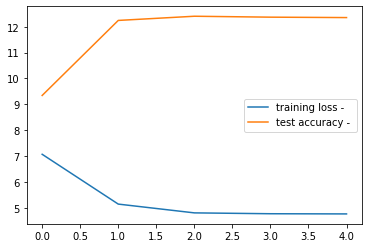

In [14]:
test_accs, top_k_accs, top_k_mrrs, losses, best_model, best_acc, test_loader = train(config) 

print(f'test_accs : {max(test_accs)}, top_k_accs : {max(top_k_accs)}, top_k_mrrs : {top_k_mrrs}')
print("Maximum test set accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))

plt.plot(losses, label="training loss" + " - ")
plt.plot(test_accs, label="test accuracy" + " - ")
plt.legend()
fig = plt.gcf()
fig.savefig('train_loss_test_acc_diginetica_srgnn_light.pdf')
plt.show()

In [17]:
top_k_mrrs

0.1877394692129855

In [18]:
mrr20 = [0.14799833654704023,0.18549039884094218,0.18782402697095596,  0.18777815849202914, 0.1877394692129855]

In [21]:
top_k_accs = [0.4594354177380572,
 0.528903220426147,
 0.5322251101505274,
 0.53247529431387,
 0.5324613951936843]

[0.4594354177380572,
 0.528903220426147,
 0.5322251101505274,
 0.53247529431387,
 0.5324613951936843]

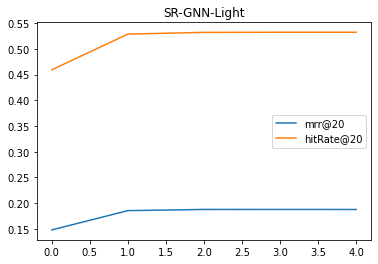

In [20]:
plt.plot(mrr20, label="mrr@20")
plt.plot(top_k_accs, label="hitRate@20")
plt.legend()
plt.title('SR-GNN-Light')
f = plt.gcf()
f.savefig("srgnn_light_mrr@20_hitrate@20_validation_set.pdf")
plt.show()

In [12]:
hyper_yoochoose =  {'l2_penalty': 1e-05, 'lr': 0.0033144396293236108, 'epochs': 5, 'batch_size': 128, 'hidden_dim': 125, 'step': 3, 'weight_decay': 0.1, 'K': 1, 'num_items': 37484, 'model_type': 'lightgcn', 'normalize': True}